In [18]:
import torch
import torchvision
from torchvision import datasets
from torch import nn, optim, autograd
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import numpy as np
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, homogeneity_score, completeness_score, v_measure_score
from sklearn.model_selection import KFold

#from google.colab import drive

import itertools
import pandas as pd
import pickle as pkl
import os
import seaborn as sns
import sys    

In [2]:
#drive.mount('/content/drive', force_remount=True) 

Mounted at /content/drive


In [8]:
# needed to import external py modules
path_py_modules = os.path.join(os.getcwd(), '../py_modules')
sys.path.append(path_py_modules) 

In [19]:
from models import MLP, CNN, CNN3
from datasets import CustomDatasetCMNIST, inject_ColorBias, generate_CMNIST
from model_utils import train_reference, test_reference, train_subgroup, test_subgroup, train_subgroup_noadv, DemographicParityGap, EqualizedOddsGap, n_runs_subgroupAdvTrain_v2, n_runs_subgroupNoAdv
from utils import examples_CMNIST, display_confs, plot_subgroup_losses, plot_hist_subgroups, plot_loss_noadv

# Biased dataset

Class 0
  Number of samples: tensor(5842)
  Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
  Colors: tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 0])
  Agreement colors/labels (accross the whole class): 95.019%


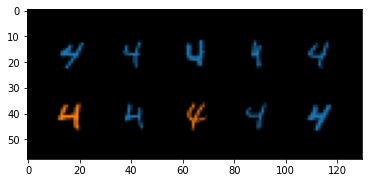

Class 1
  Number of samples: tensor(5949)
  Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
  Colors: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
  Agreement colors/labels (accross the whole class): 94.823%


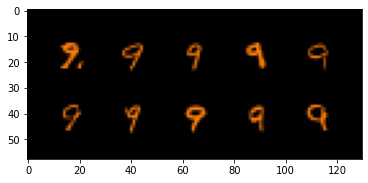

In [6]:
tr_data = generate_CMNIST(train=True, main_color_prop=0.95, class_colors=[0,1], downsample=True, classes=[4,9])
examples_CMNIST(tr_data)

Class 0
  Number of samples: tensor(982)
  Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])
  Colors: tensor([1, 1, 1, 1, 0, 1, 1, 1, 1, 1])
  Agreement colors/labels (accross the whole class): 9.267%


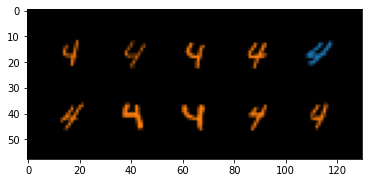

Class 1
  Number of samples: tensor(1009)
  Labels: tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
  Colors: tensor([0, 0, 0, 1, 1, 0, 0, 1, 0, 0])
  Agreement colors/labels (accross the whole class): 9.713%


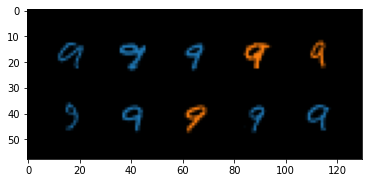

In [ ]:
te_data = generate_CMNIST(train=False, main_color_prop=0.1, class_colors=[0,1], downsample=True, classes=[4,9])
examples_CMNIST(te_data)

# Reduced CMNIST: 2 classes (digits), 2 subgroups (colors)

## Train reference classifier with ERM

In [20]:
BATCH_SIZE = 4096 
cmnist_tr = CustomDatasetCMNIST(train=True, main_color_prop=0.95, class_colors=[0,1], classes=[4,9])
train_loader = torch.utils.data.DataLoader(cmnist_tr,batch_size=BATCH_SIZE,shuffle=True,num_workers=0) # problem with num_worker>0 ??
cmnist_te = CustomDatasetCMNIST(train=False, main_color_prop=0.1, class_colors=[0,1], classes=[4,9], means=cmnist_tr.means, stds=cmnist_tr.stds)
test_loader = torch.utils.data.DataLoader(cmnist_te,batch_size=BATCH_SIZE,shuffle=True,num_workers=0)

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# reference classifier
ref_clf = MLP(n_layers=3, input_dim=3*14*14, hidden_dim=256, output_dim=2).to(device)

# cross entropy loss, SGD
# optimizer_ref = optim.Adam(ref_clf.parameters(), lr=0.1) # more robust to bias
optimizer_ref = optim.SGD(ref_clf.parameters(), lr=0.1)
n_epochs = 8

ref_clf, loss = train_reference(ref_clf, train_loader, optimizer_ref, nn.CrossEntropyLoss(), n_epochs, device)

Epoch 0: loss=0.58456
Epoch 7: loss=0.14817


Average accuracy: 0.95056


accuracy
label subgroup          
0     0          1.00000
      1          0.00365
1     0          0.00641
      1          1.00000

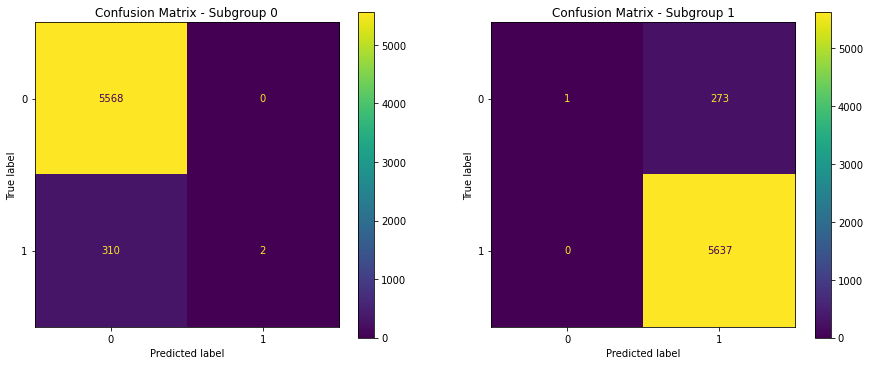

In [22]:
df, confs = test_reference(ref_clf, train_loader, device)
display(df)
print()
display_confs(confs)

Average accuracy: 0.10648


accuracy
label subgroup          
0     0         1.000000
      1         0.003405
1     0         0.001109
      1         1.000000

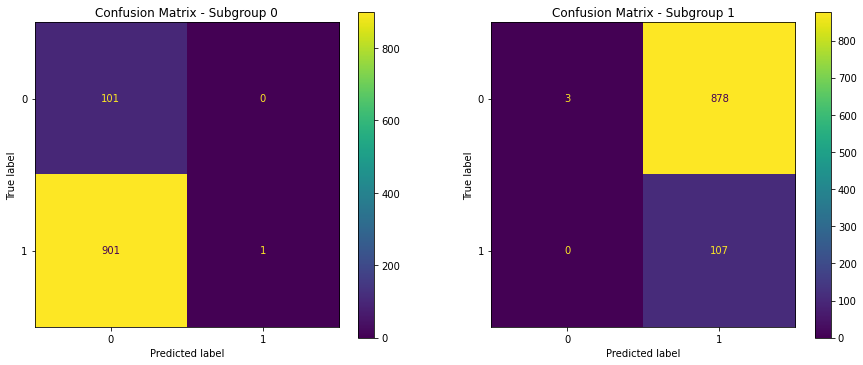

In [23]:
df, confs = test_reference(ref_clf, test_loader, device)
display(df)
print()
display_confs(confs)

## Subgroup label prediction

Based only on demographic parity gap.

In [12]:
# get biased preds 
for i in range(cmnist_tr.__len__()):
   _, img, _, _, _ = cmnist_tr.__getitem__(i)
   img = img.to(device)
   out, _ = ref_clf(img[None, :, :, :])
   out = nn.Softmax(dim=-1)(out)
   cmnist_tr.biased_predictions[i] = torch.argmax(out, dim=1).cpu().item()

In [13]:
# check demographic parity gap for true subgroups
num_classes=2
num_subgroups=2
out = nn.functional.one_hot(cmnist_tr.subgroup).float()
biased_preds = cmnist_tr.biased_predictions.long()

-DemographicParityGap(print_gaps=True)(out, biased_preds, None, num_classes, num_subgroups, torch.device('cpu'))

tensor([[0.9990],
        [0.9990]])


tensor(0.9990)

In [14]:
# check demographic parity gap for subgroups based on bp
num_classes=2
num_subgroups=2
out = nn.functional.one_hot(cmnist_tr.biased_predictions.long()).float()
biased_preds = cmnist_tr.biased_predictions.long()

-DemographicParityGap(print_gaps=True)(out, biased_preds, None, num_classes, num_subgroups, torch.device('cpu'))

tensor([[1.],
        [1.]])


tensor(1.)

In [ ]:
#without adversary+MI 
model = MLP(n_layers=3, input_dim=3*14*14, hidden_dim=256, output_dim=2)
results = n_runs_subgroupNoAdv(n_runs=10, n_epochs=20, num_classes=2, num_subgroups=2, dataset_tr=cmnist_tr, dataset_te=cmnist_te,
                               lr=0.01, loss_fn=DemographicParityGap(), train_loader=train_loader, test_loader=test_loader, 
                               device=device, model=model)

--------Run 0--------
Train homogeneity score: 0.999 ; Train completeness score: 0.999
Test homogeneity score: 1.000 ; Test completeness score: 1.000
--------Run 1--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
--------Run 2--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
--------Run 3--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
--------Run 4--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
--------Run 5--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
--------Run 6--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogene

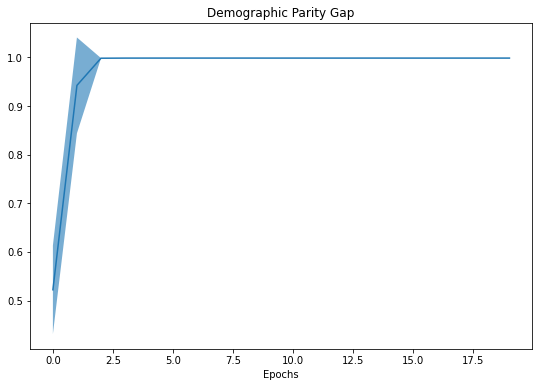

In [ ]:
plot_loss_noadv(results['epoch_loss'], 'Demographic Parity Gap')

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.996795
1     0                 0.996633
      1                 0.999823

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.993590
1     0                 0.996633
      1                 0.999823

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.993590
1     0                 0.996633
      1                 0.999823

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.993590
1     0                 0.996633
      1                 0.999823

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.993590
1     0                 0.996633
      1                 0.999823

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.993590
1     0                 0.996633
      1                 0.999823

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.993590
1     0                 0.996633
      1                 0.999823

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.993590
1     0                 0.996633
      1                 0.999823

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.993590
1     0                 0.996633
      1                 0.999823

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.993590
1     0                 0.996633
      1                 0.999823

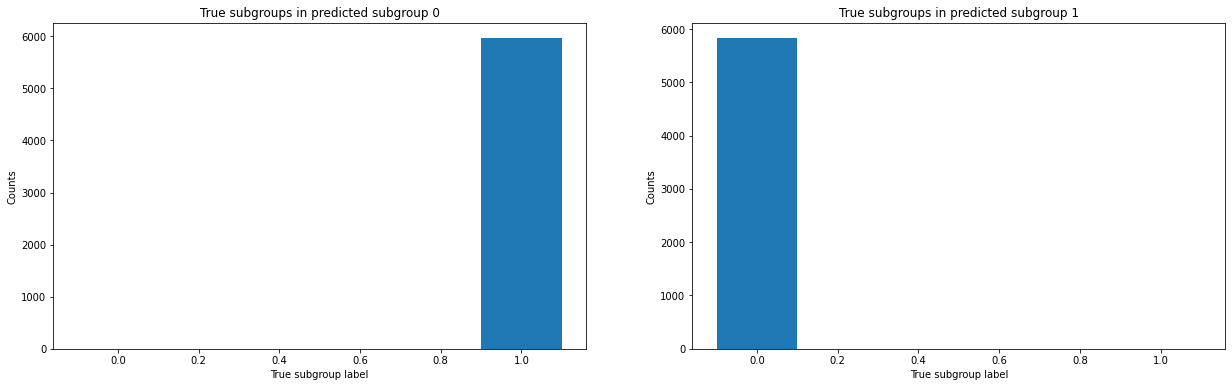

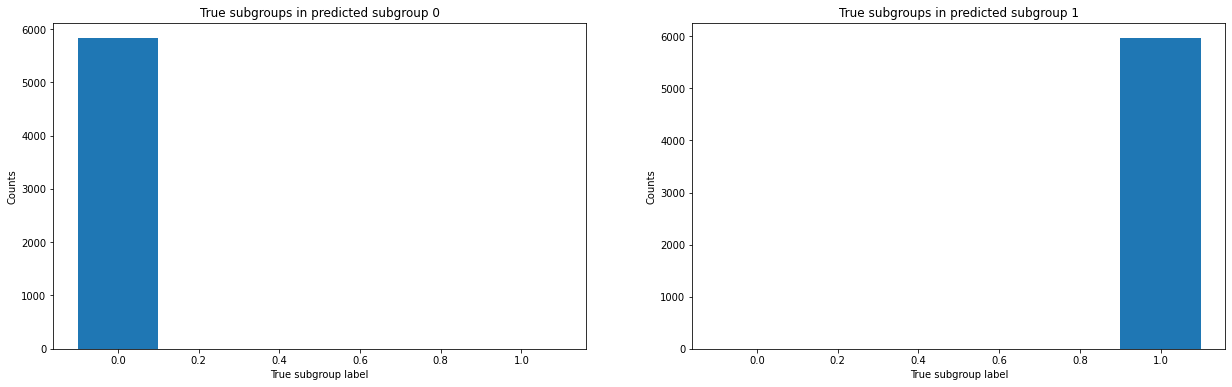

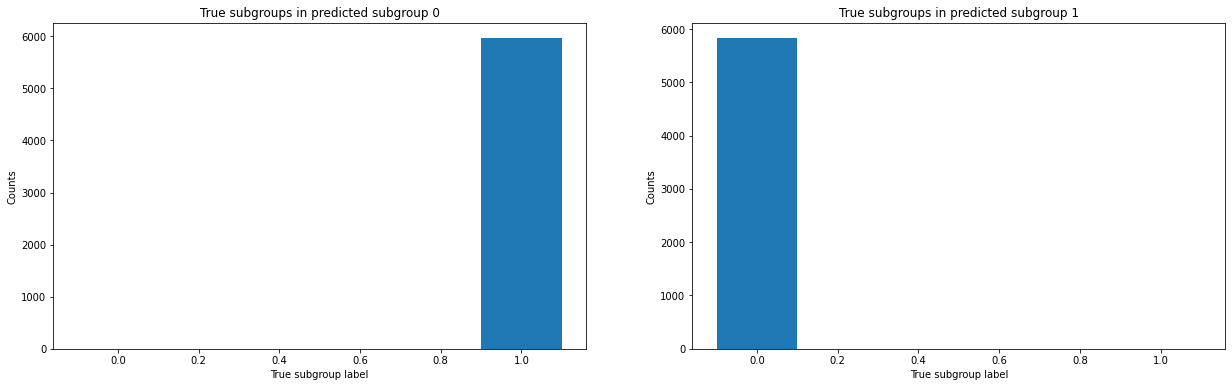

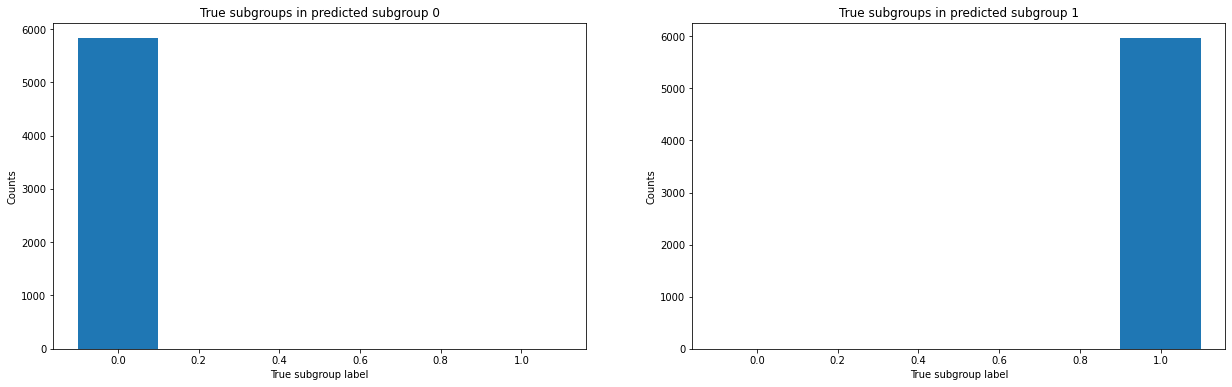

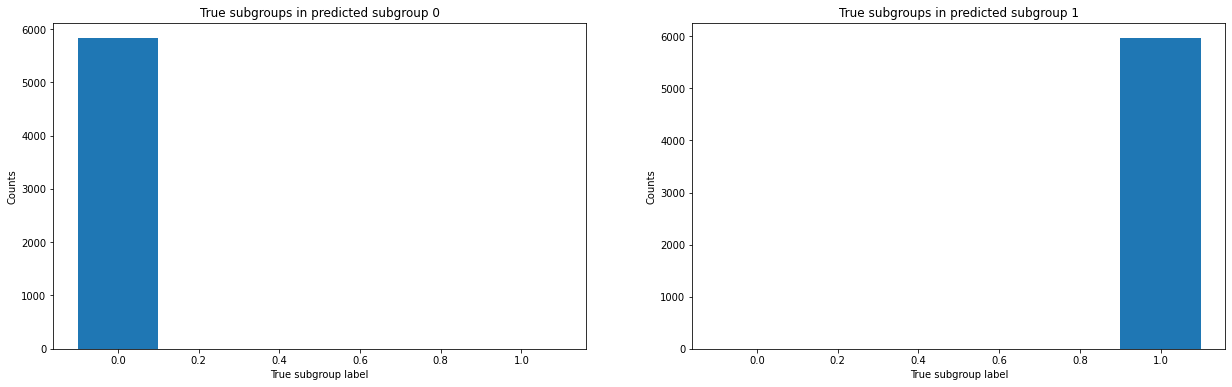

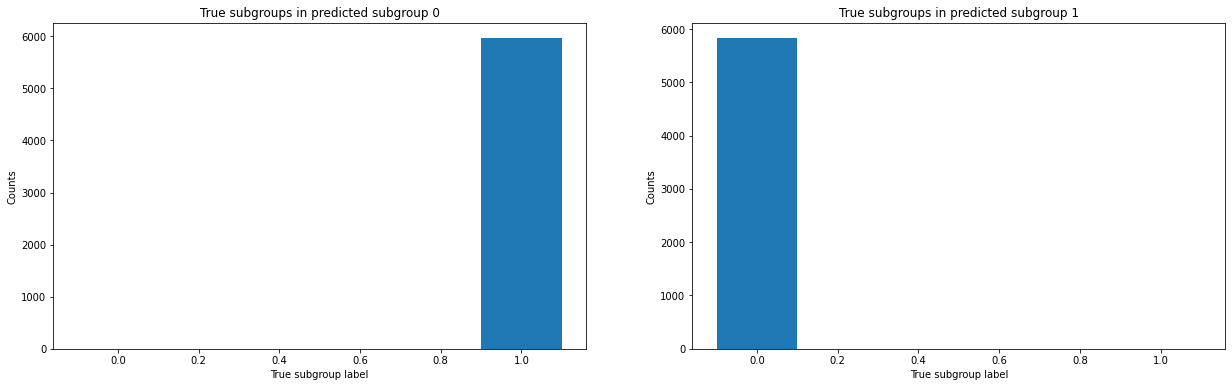

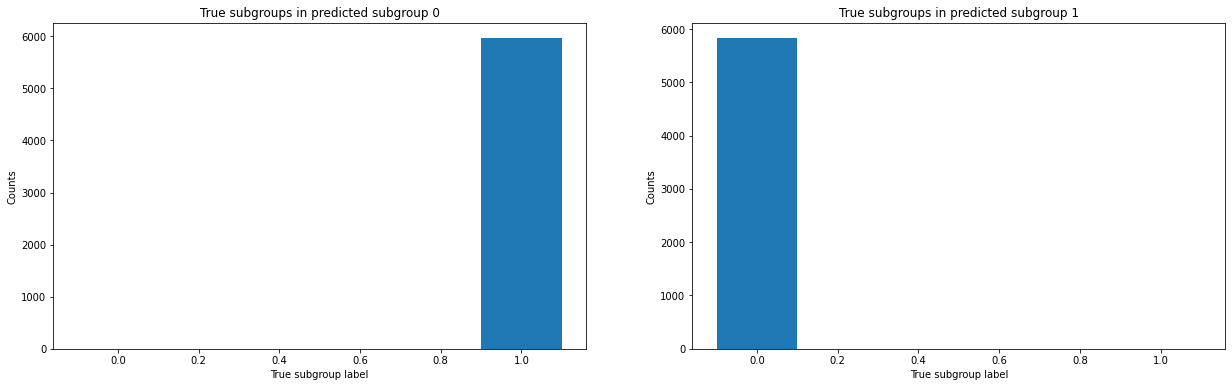

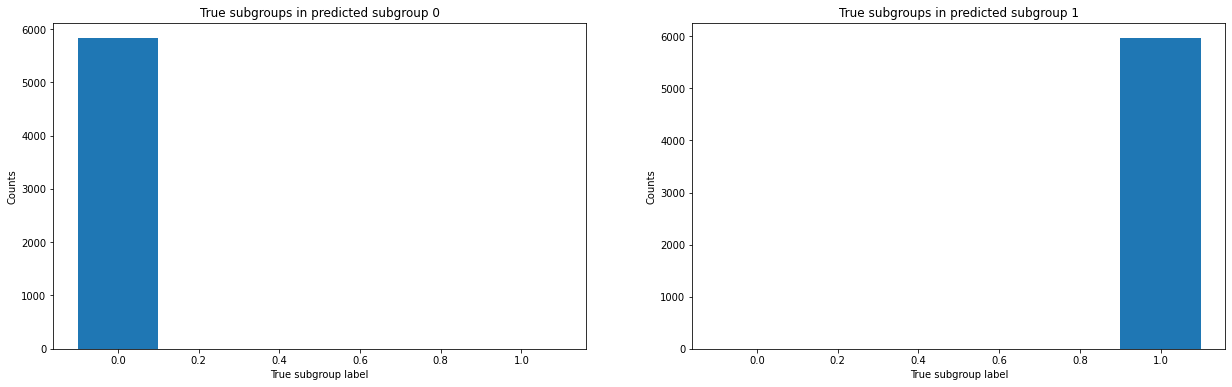

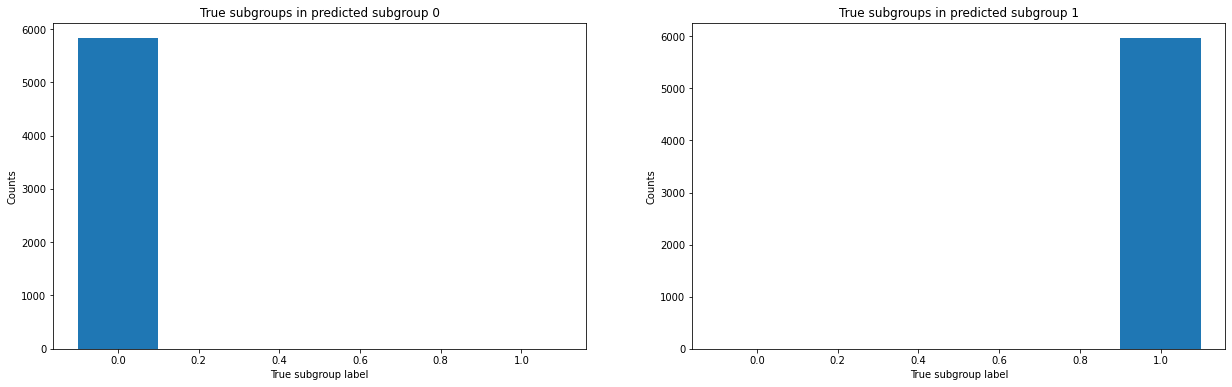

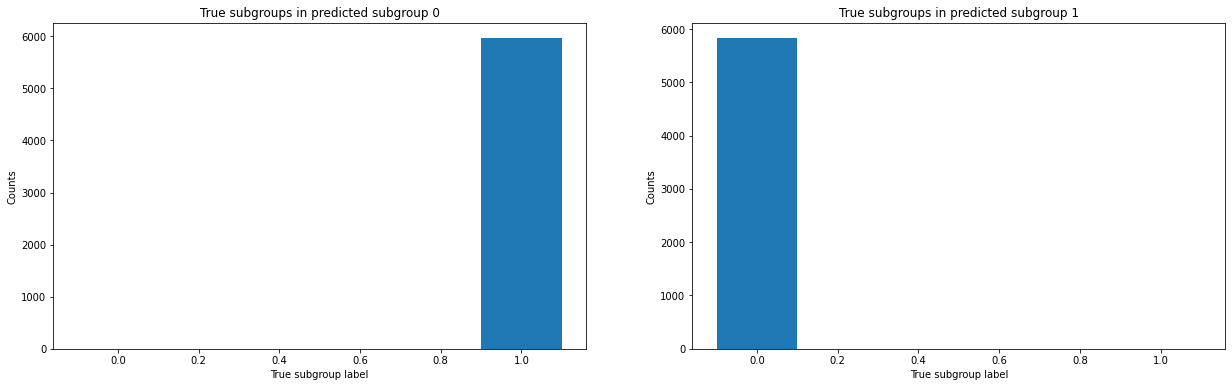

In [ ]:
plot_hist_subgroups(n_runs=10, num_subgroups=2, dataset=cmnist_tr, indices=results['idx_tr'], 
                    probs=results['probs_tr'], check_bp=True)

## Subgroup label prediction with MI regularizer

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learner = MLP(n_layers=3, input_dim=3*14*14, hidden_dim=64, output_dim=2)
adv = MLP(n_layers=1, input_dim=64, hidden_dim=64, output_dim=2)
results = n_runs_subgroupAdvTrain_v2(n_runs=10, n_epochs=30, dataset_tr=cmnist_tr, dataset_te=cmnist_te, device=device, 
                                     num_classes=2, num_subgroups=2, train_loader=train_loader, test_loader=test_loader,
                                     model_learner=learner, model_adv=adv, loss_fn_learner=DemographicParityGap(), loss_fn_adv=nn.CrossEntropyLoss(), 
                                     lr=0.01, lr_adv=0.001, mi_weight=1., verbose=False, same_weight_init=False, l2_reg=0, anomaly_detection=False) 

--------Run 0--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Adversary train accuracy (target=biased predictions): 0.99864
--------Run 1--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Adversary train accuracy (target=biased predictions): 0.50437
--------Run 2--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Adversary train accuracy (target=biased predictions): 0.00170
--------Run 3--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Adversary train accuracy (target=biased predictions): 0.50428
--------Run 4--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Ad

In [18]:
with open('../results/cmnist_2_2_dpg.pkl', 'wb') as f:
  pkl.dump(results, f)

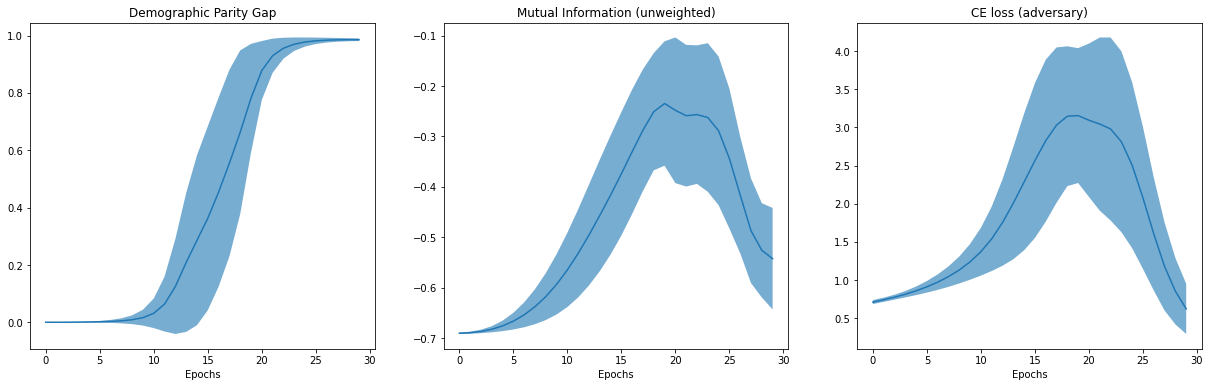

In [19]:
plot_subgroup_losses(results['epoch_loss'], results['epoch_mi'], results['epoch_loss_adv'])

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.950820
1     0                 1.000000
      1                 0.999823

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.950820
1     0                 1.000000
      1                 0.999823

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.950820
1     0                 1.000000
      1                 0.999823

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.950820
1     0                 1.000000
      1                 0.999823

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.950820
1     0                 1.000000
      1                 0.999823

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.950820
1     0                 1.000000
      1                 0.999823

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.950820
1     0                 1.000000
      1                 0.999823

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.950820
1     0                 1.000000
      1                 0.999823

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.950820
1     0                 1.000000
      1                 0.999823

acc_biased_preds
label subgroup                  
0     0                 1.000000
      1                 0.950820
1     0                 1.000000
      1                 0.999823

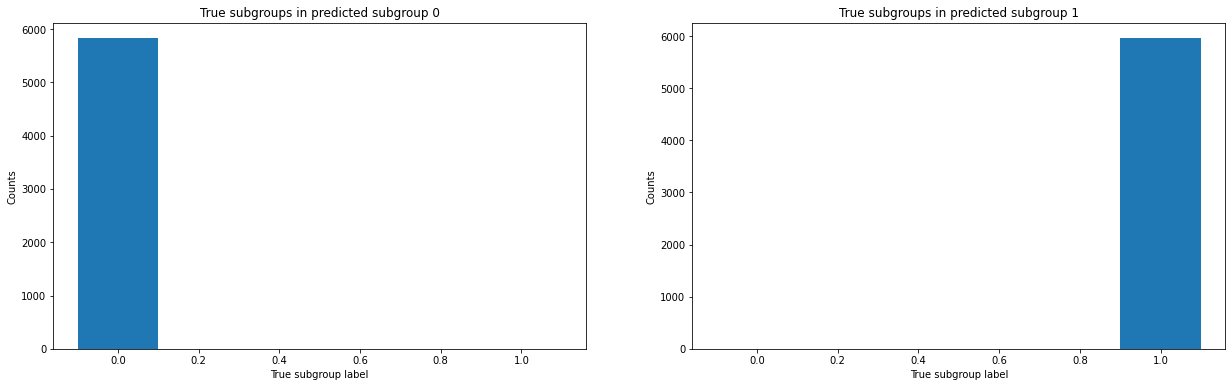

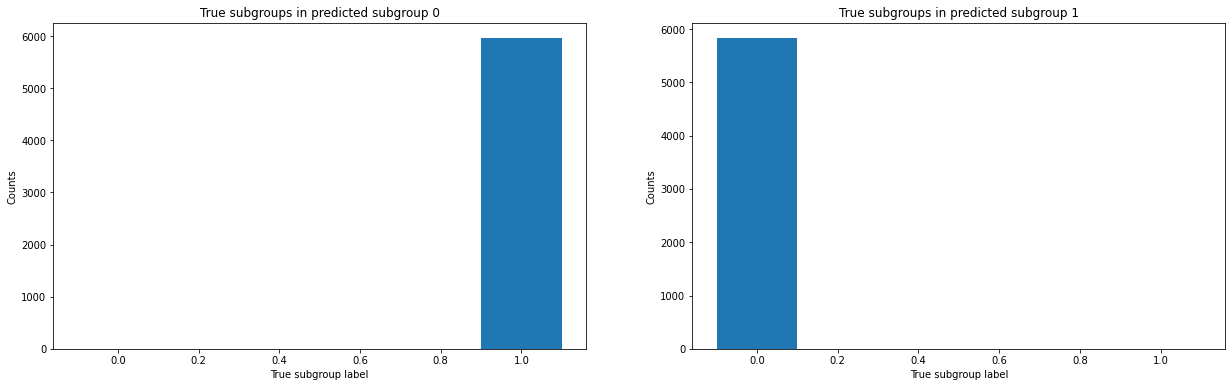

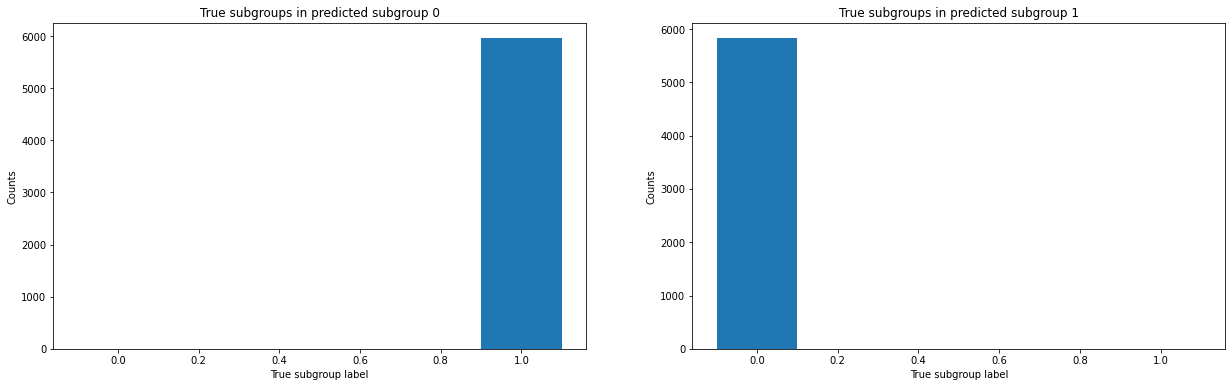

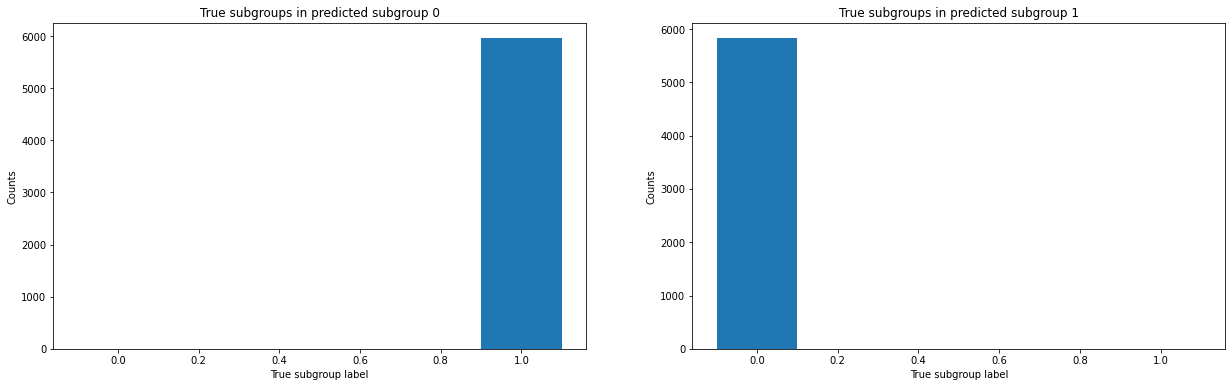

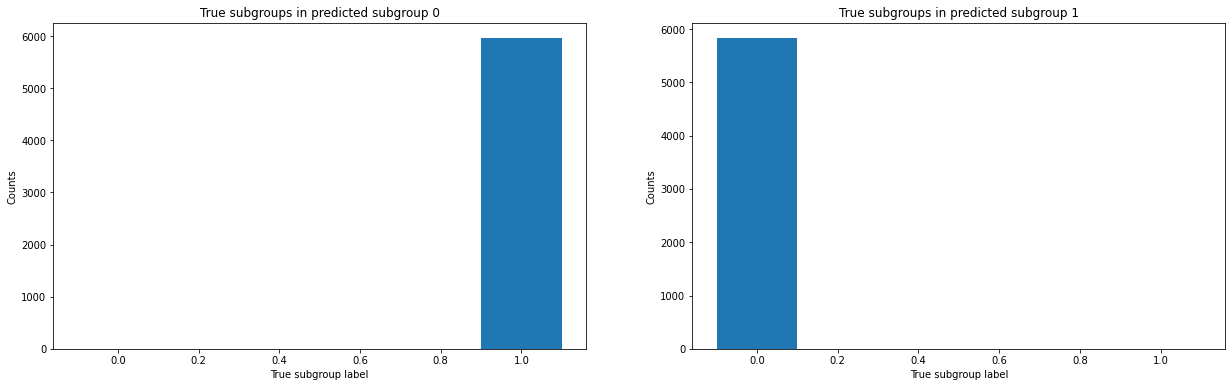

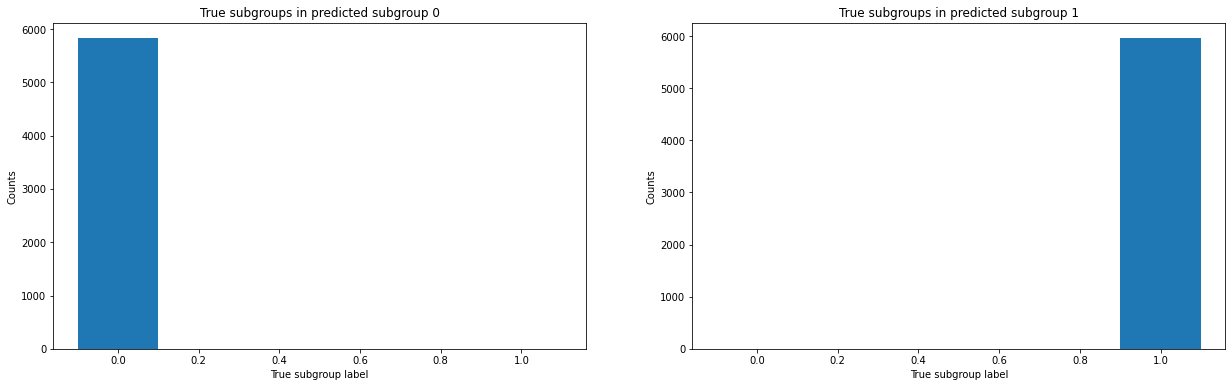

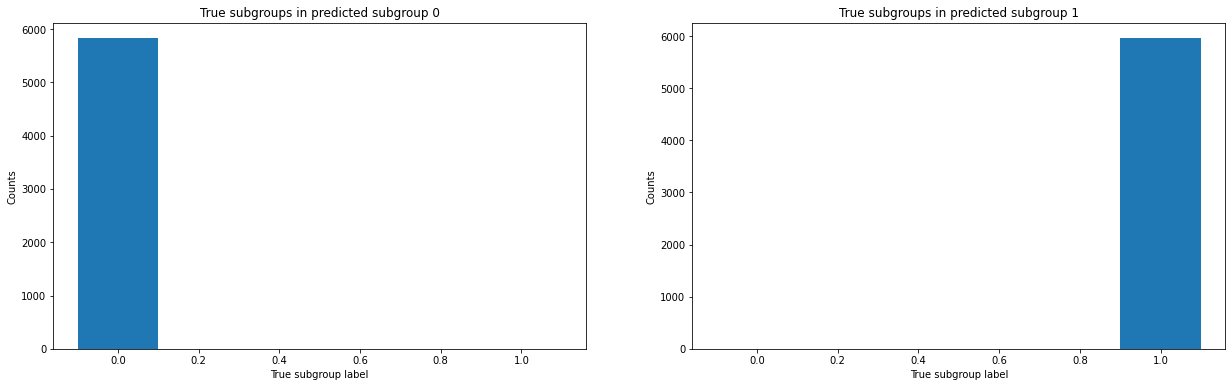

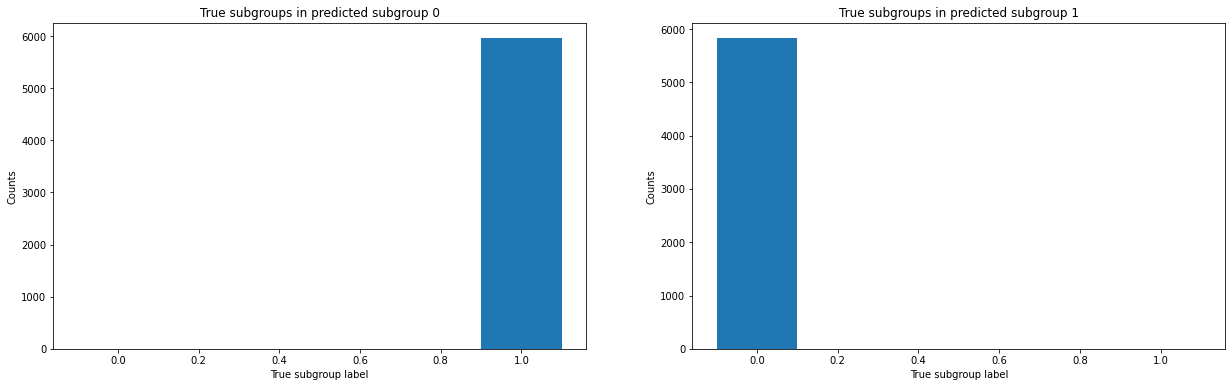

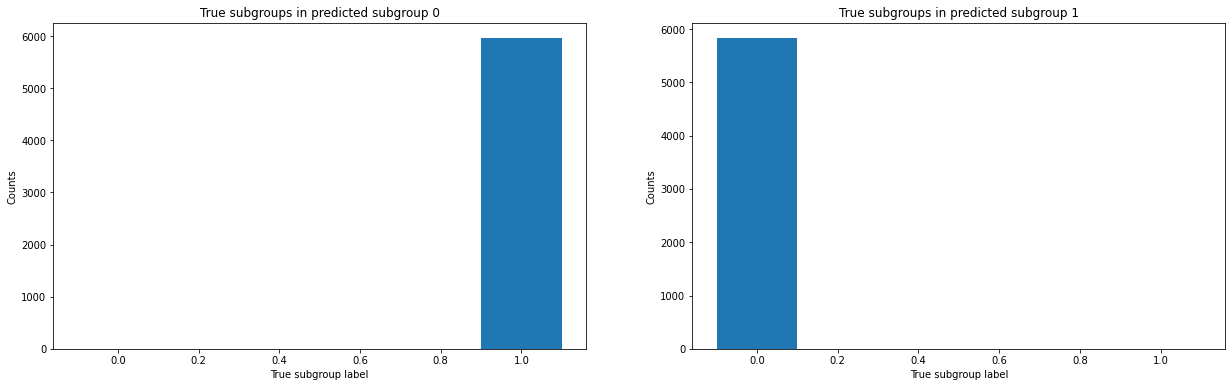

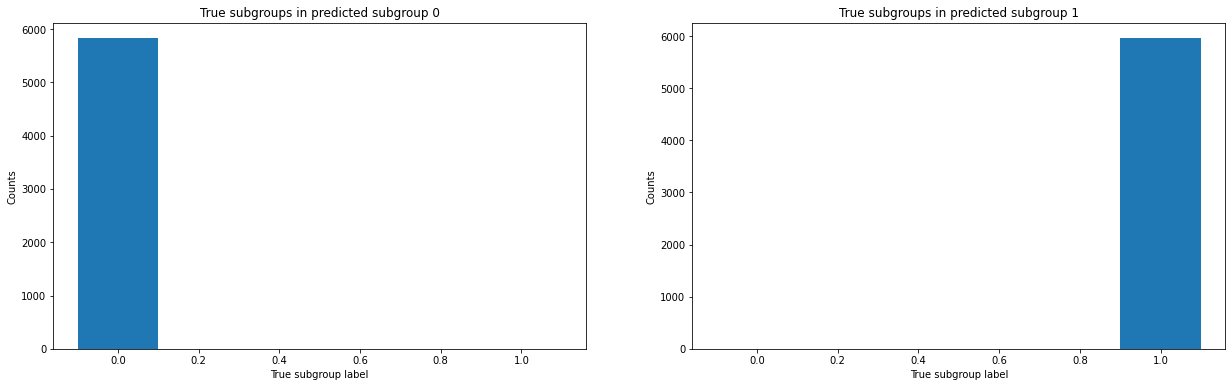

In [20]:
plot_hist_subgroups(n_runs=10, num_subgroups=2, dataset=cmnist_tr, indices=results['idx_tr'], 
                    probs=results['probs_tr'], check_bp=True)

In [ ]:
# plot each run separately - not shown here as they are all very similar
for i in range(10):
  plot_subgroup_losses(results['epoch_loss'], results['epoch_mi'], results['epoch_loss_adv'], runs=[i])

In [ ]:
# test with Eq. Odds - works too, but also seems less stable than dpg + needs more epochs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learner = MLP(n_layers=3, input_dim=3*14*14, hidden_dim=64, output_dim=2)
adv = MLP(n_layers=1, input_dim=64, hidden_dim=64, output_dim=2)
results = n_runs_subgroupAdvTrain_v2(n_runs=10, n_epochs=40, dataset_tr=cmnist_tr, dataset_te=cmnist_te, device=device, 
                                     num_classes=2, num_subgroups=2, train_loader=train_loader, test_loader=test_loader,
                                     model_learner=learner, model_adv=adv, loss_fn_learner=EqualizedOddsGap(), loss_fn_adv=nn.CrossEntropyLoss(), 
                                     lr=0.01, lr_adv=0.001, mi_weight=1., verbose=False, same_weight_init=False, l2_reg=0, anomaly_detection=False) 

--------Run 0--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Adversary train accuracy (target=biased predictions): 0.50420
--------Run 1--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Adversary train accuracy (target=biased predictions): 0.99695
--------Run 2--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Adversary train accuracy (target=biased predictions): 0.98372
--------Run 3--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Adversary train accuracy (target=biased predictions): 0.99695
--------Run 4--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Ad

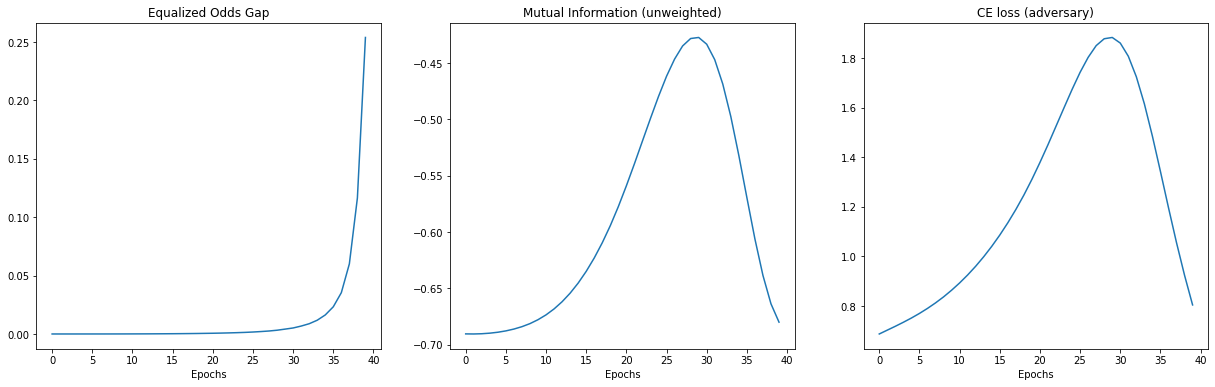

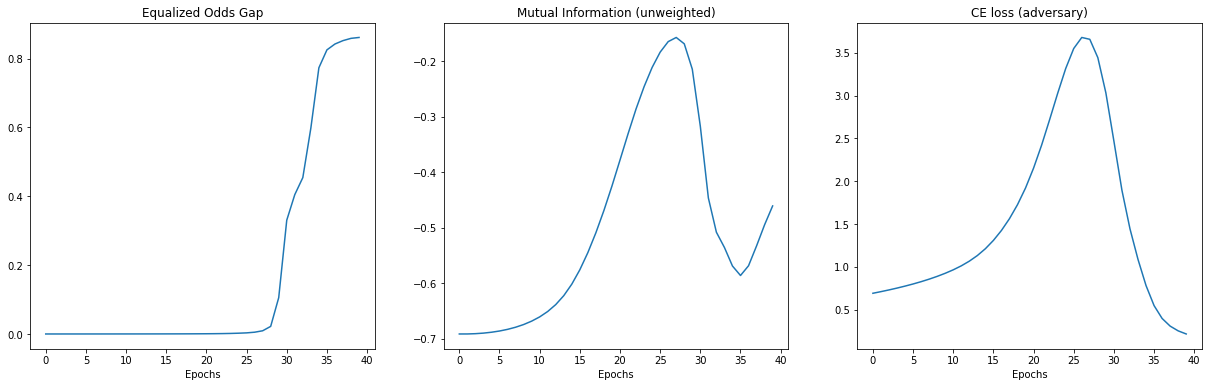

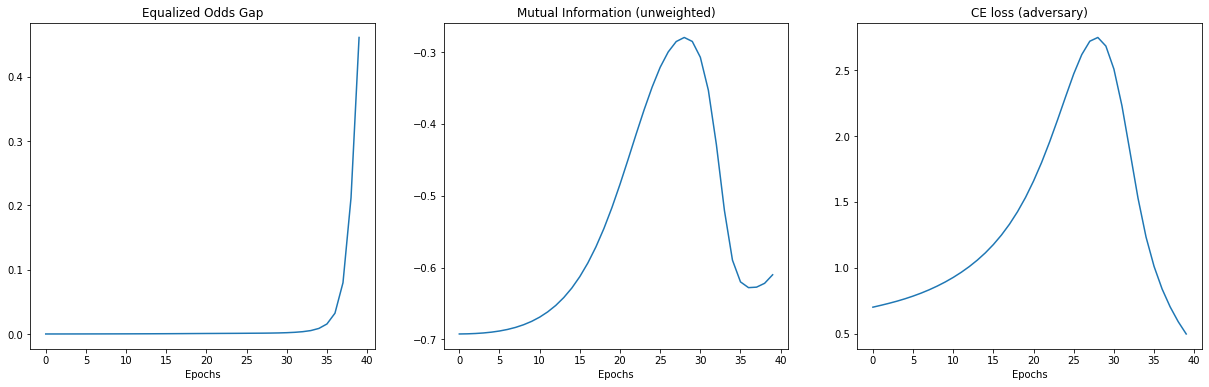

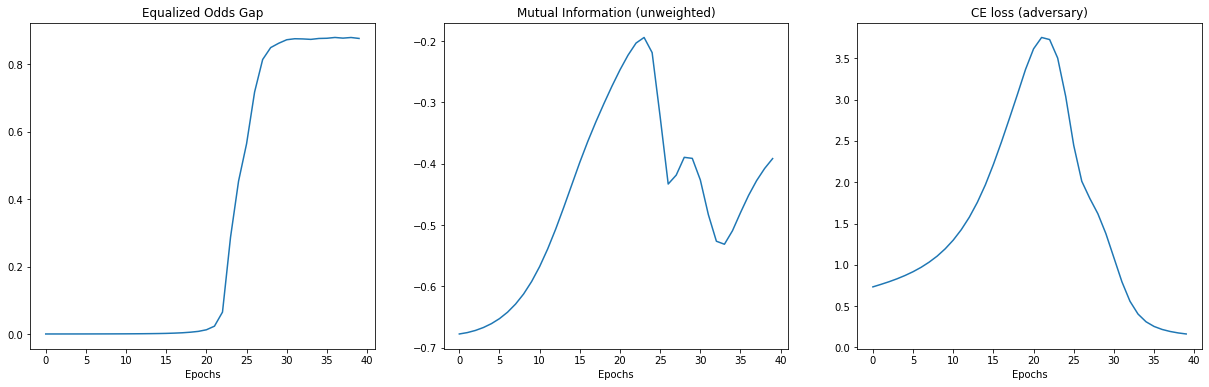

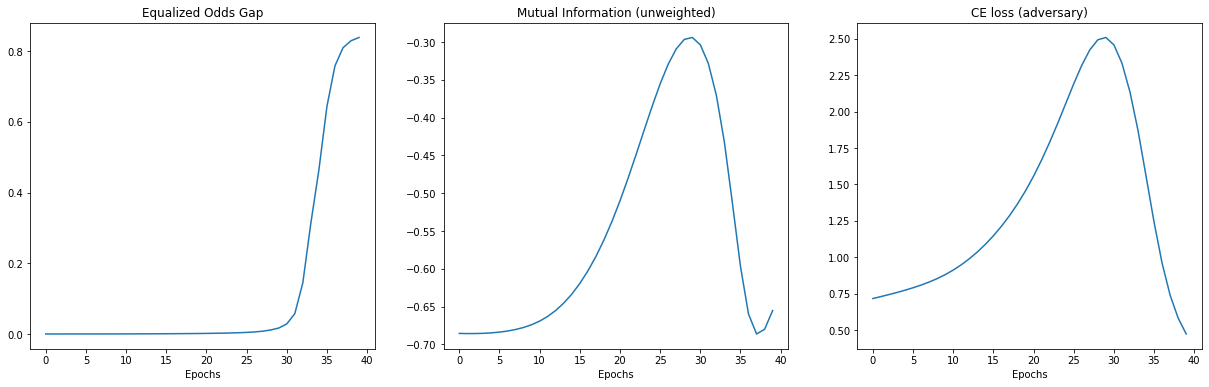

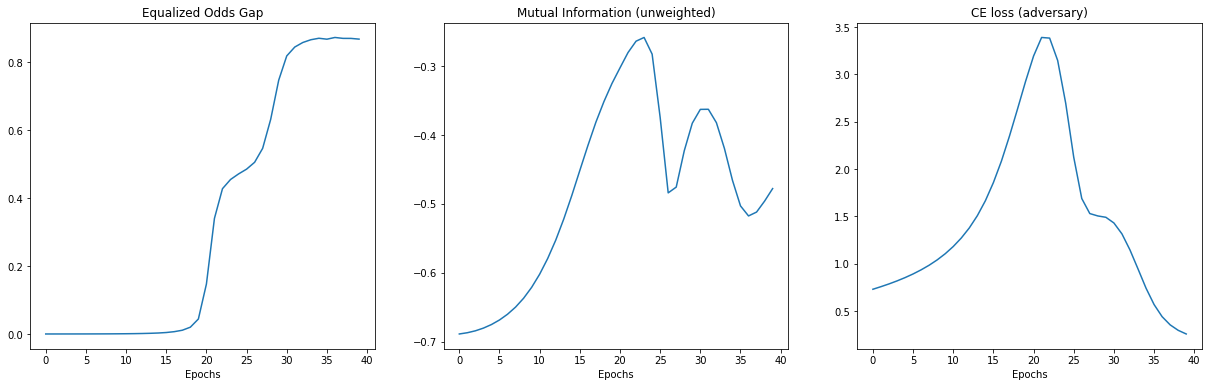

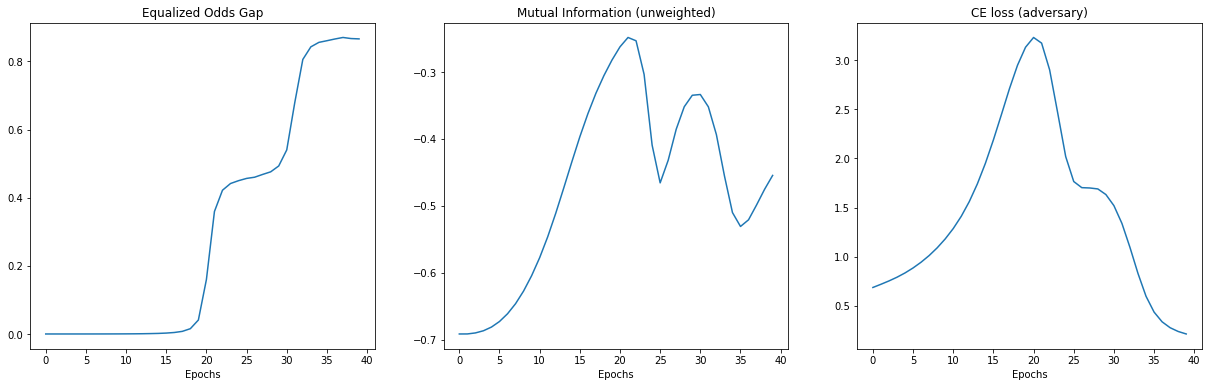

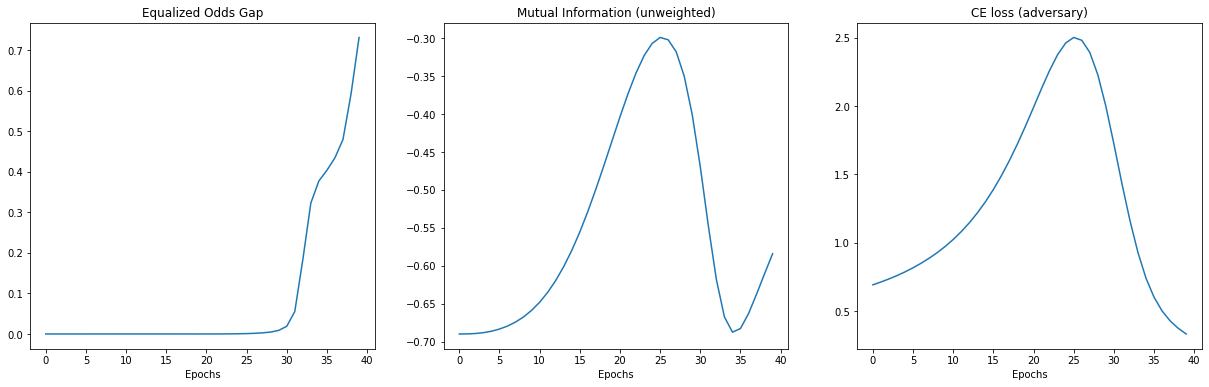

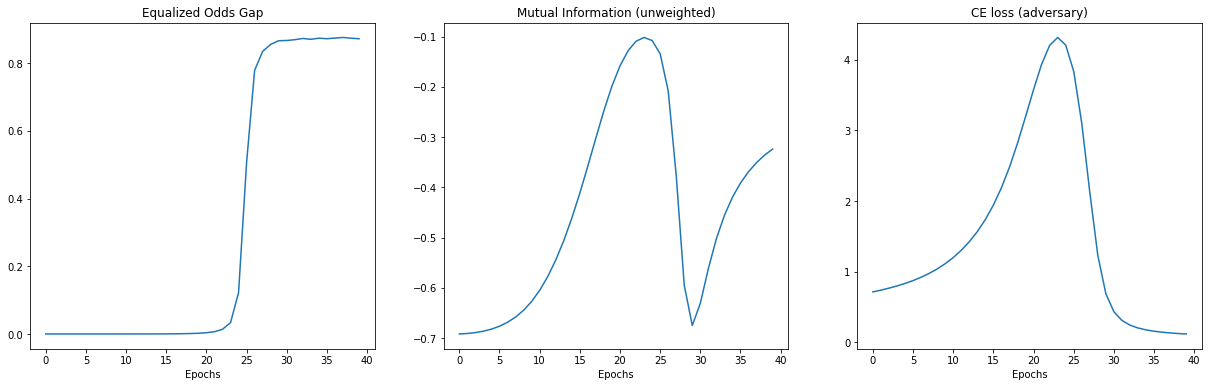

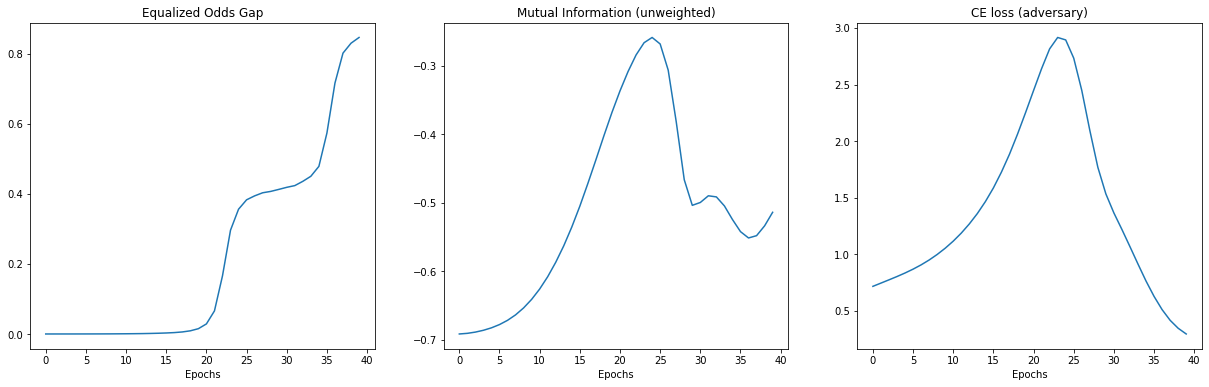

In [ ]:
for i in range(10):
  plot_subgroup_losses(results['epoch_loss'], results['epoch_mi'], results['epoch_loss_adv'], runs=[i], loss_name='Equalized Odds Gap')

# Reduced CMNIST: 3 classes (digits), 3 subgroups (colors)

In [5]:
BATCH_SIZE = 4096 
cmnist_tr = CustomDatasetCMNIST(train=True, main_color_prop=0.9, class_colors=[0,1,2], classes=[4,7,9])
train_loader = torch.utils.data.DataLoader(cmnist_tr,batch_size=BATCH_SIZE,shuffle=True,num_workers=0) 
cmnist_te = CustomDatasetCMNIST(train=False, main_color_prop=0.1, class_colors=[0,1,2], classes=[4,7,9], means=cmnist_tr.means, stds=cmnist_tr.stds)
test_loader = torch.utils.data.DataLoader(cmnist_te,batch_size=BATCH_SIZE,shuffle=True,num_workers=0)

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# reference classifier
ref_clf = MLP(n_layers=3, input_dim=3*14*14, hidden_dim=256, output_dim=3).to(device)
optimizer_ref = optim.SGD(ref_clf.parameters(), lr=0.1)
n_epochs = 3 

ref_clf, loss = train_reference(ref_clf, train_loader, optimizer_ref, nn.CrossEntropyLoss(), n_epochs, device)

Epoch 0: loss=0.92276
Epoch 2: loss=0.33699


Train set
Average accuracy: 0.89942


accuracy
label subgroup          
0     0         0.999431
      1         0.000000
      2         0.010638
1     0         0.006452
      1         0.993960
      2         0.009202
2     0         0.027950
      1         0.040000
      2         0.999813

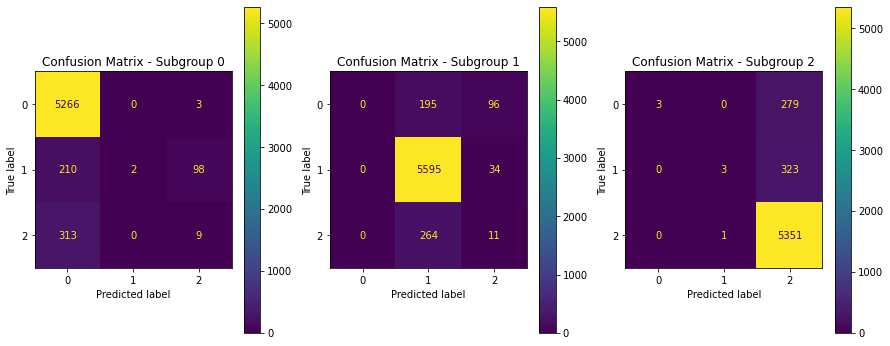

In [7]:
print('Train set')
df, confs = test_reference(ref_clf, train_loader, device)
display(df)
print()
display_confs(confs)

Test set
Average accuracy: 0.11659


accuracy
label subgroup          
0     0         1.000000
      1         0.000000
      2         0.000000
1     0         0.004211
      1         0.989691
      2         0.004386
2     0         0.013043
      1         0.072893
      2         1.000000

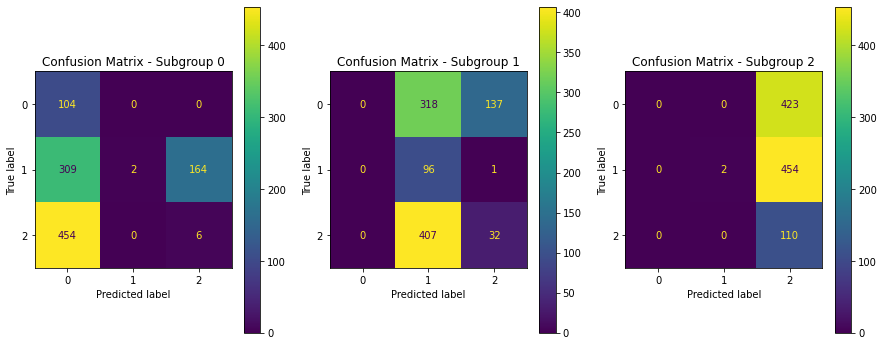

In [8]:
print('Test set')
df, confs = test_reference(ref_clf, test_loader, device)
display(df)
print()
display_confs(confs)

In [ ]:
device_cpu = torch.device('cpu')
torch.save(ref_clf.to(device_cpu), '../results/ref_clf_cmnist_4_7_9_3colors.pkl')

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ref_clf = torch.load('../results/ref_clf_cmnist_4_7_9_3colors.pkl').to(device)

In [9]:
# get biased preds
for i in range(cmnist_tr.__len__()):
   _, img, _, _, _ = cmnist_tr.__getitem__(i)
   img = img.to(device)
   out, _ = ref_clf(img[None, :, :, :])
   out = nn.Softmax(dim=-1)(out)
   cmnist_tr.biased_predictions[i] = torch.argmax(out, dim=1).cpu().item()

In [13]:
# check demographic parity gap for true subgroups
num_classes=3
num_subgroups=3
out = nn.functional.one_hot(cmnist_tr.subgroup).float()
biased_preds = cmnist_tr.biased_predictions.long()

-DemographicParityGap(print_gaps=True)(out, biased_preds, None, num_classes, num_subgroups, torch.device('cpu'))

tensor([[9.5734e-01, 9.5734e-01, 0.0000e+00],
        [9.5495e-01, 7.2737e-13, 9.5495e-01],
        [1.4925e-06, 9.5734e-01, 9.5495e-01]])


tensor(0.6374)

In [14]:
# check demographic parity gap for subgroups based on bp
num_classes=3
num_subgroups=3
out = nn.functional.one_hot(cmnist_tr.biased_predictions.long()).float()
biased_preds = cmnist_tr.biased_predictions.long()

-DemographicParityGap(print_gaps=True)(out, biased_preds, None, num_classes, num_subgroups, torch.device('cpu'))

tensor([[1., 1., 0.],
        [1., 0., 1.],
        [0., 1., 1.]])


tensor(0.6667)

## Subgroup Label Prediction

In [10]:
#BATCH_SIZE = cmnist_tr.__len__()
BATCH_SIZE = 512
train_loader = torch.utils.data.DataLoader(cmnist_tr,batch_size=BATCH_SIZE,shuffle=True,num_workers=0) 

In [16]:
#without adversary+MI 
model = MLP(n_layers=3, input_dim=3*14*14, hidden_dim=256, output_dim=3)
results = n_runs_subgroupNoAdv(n_runs=10, n_epochs=30, num_classes=3, num_subgroups=3, dataset_tr=cmnist_tr, dataset_te=cmnist_te,
                               lr=0.001, loss_fn=DemographicParityGap(), train_loader=train_loader, test_loader=test_loader, 
                               device=device, model=model)

--------Run 0--------
Train homogeneity score: 0.585 ; Train completeness score: 1.000
Test homogeneity score: 0.578 ; Test completeness score: 1.000
--------Run 1--------
Train homogeneity score: 0.928 ; Train completeness score: 0.929
Test homogeneity score: 0.667 ; Test completeness score: 0.690
--------Run 2--------
Train homogeneity score: 0.937 ; Train completeness score: 0.937
Test homogeneity score: 0.717 ; Test completeness score: 0.733
--------Run 3--------
Train homogeneity score: 0.954 ; Train completeness score: 0.954
Test homogeneity score: 0.779 ; Test completeness score: 0.784
--------Run 4--------
Train homogeneity score: 0.938 ; Train completeness score: 0.938
Test homogeneity score: 0.736 ; Test completeness score: 0.749
--------Run 5--------
Train homogeneity score: 0.934 ; Train completeness score: 0.934
Test homogeneity score: 0.714 ; Test completeness score: 0.729
--------Run 6--------
Train homogeneity score: 0.945 ; Train completeness score: 0.945
Test homogene

In [17]:
# maximum loss reached for each run
results['epoch_loss'].max(axis=1) 

array([0.32649395, 0.66068929, 0.66196728, 0.65914053, 0.65874797,
       0.65593511, 0.65796208, 0.66197127, 0.66047573, 0.66167378])

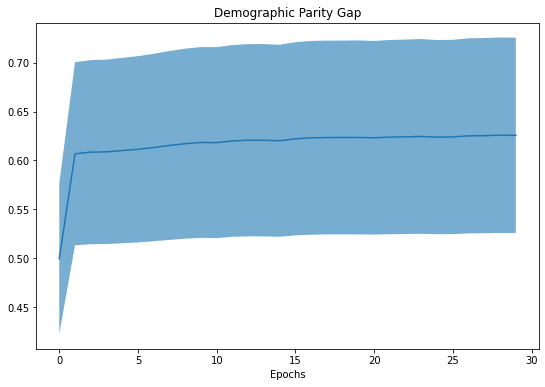

In [18]:
plot_loss_noadv(results['epoch_loss'], title='Demographic Parity Gap')

acc_biased_preds
label subgroup                  
0     0                 0.999437
      1                 0.943820
      2                 1.000000
1     0                 0.951368
      1                 0.998579
      2                 0.993506
2     0                 1.000000
      1                 0.986622
      2                 0.999814

acc_biased_preds
label subgroup                  
0     0                 0.999624
      1                 0.962547
      2                 1.000000
1     0                 0.978723
      1                 0.998045
      2                 0.996753
2     0                 0.996466
      1                 0.983278
      2                 0.999814

acc_biased_preds
label subgroup                  
0     0                 0.999249
      1                 0.913858
      2                 1.000000
1     0                 0.854103
      1                 0.997157
      2                 0.993506
2     0                 0.982332
      1                 0.969900
      2                 0.999068

acc_biased_preds
label subgroup                  
0     0                 0.999249
      1                 0.962547
      2                 1.000000
1     0                 0.893617
      1                 0.998045
      2                 0.993506
2     0                 0.985866
      1                 0.993311
      2                 0.999814

acc_biased_preds
label subgroup                  
0     0                 0.999437
      1                 0.940075
      2                 0.996016
1     0                 0.942249
      1                 0.996802
      2                 0.993506
2     0                 0.985866
      1                 0.983278
      2                 0.999814

acc_biased_preds
label subgroup                  
0     0                 0.999249
      1                 0.951311
      2                 1.000000
1     0                 0.939210
      1                 0.996802
      2                 0.993506
2     0                 0.985866
      1                 0.979933
      2                 0.999814

acc_biased_preds
label subgroup                  
0     0                 0.999437
      1                 0.951311
      2                 1.000000
1     0                 0.969605
      1                 0.997868
      2                 0.996753
2     0                 0.996466
      1                 0.983278
      2                 0.999814

acc_biased_preds
label subgroup                  
0     0                 0.999437
      1                 0.947566
      2                 1.000000
1     0                 0.905775
      1                 0.998223
      2                 1.000000
2     0                 0.992933
      1                 0.993311
      2                 0.999814

acc_biased_preds
label subgroup                  
0     0                 0.999624
      1                 0.947566
      2                 1.000000
1     0                 0.963526
      1                 0.998579
      2                 0.993506
2     0                 0.996466
      1                 0.993311
      2                 0.999814

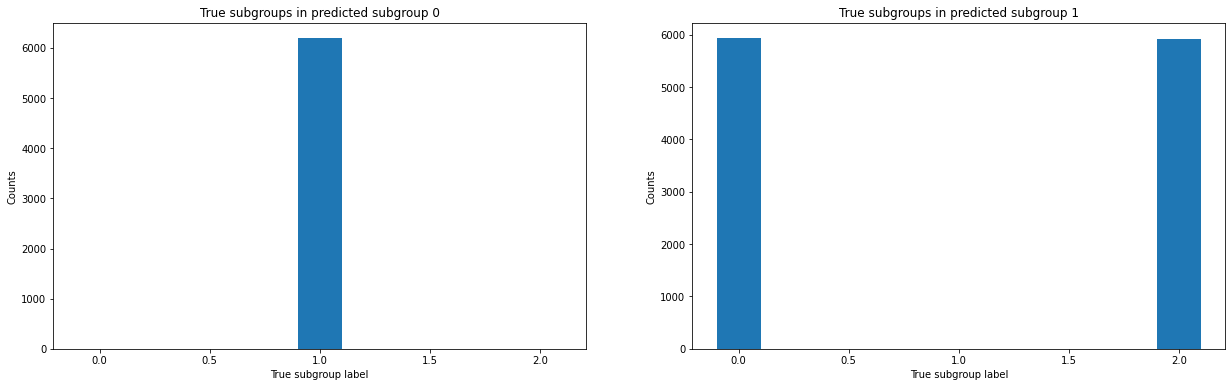

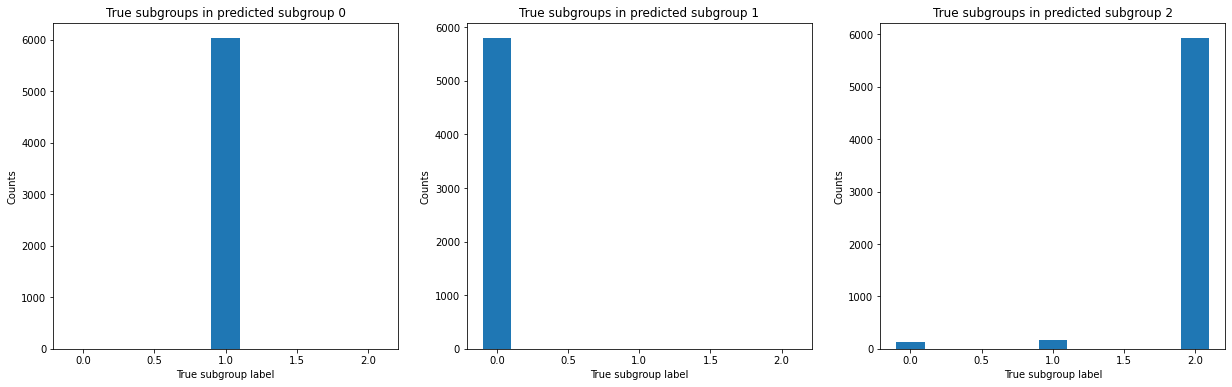

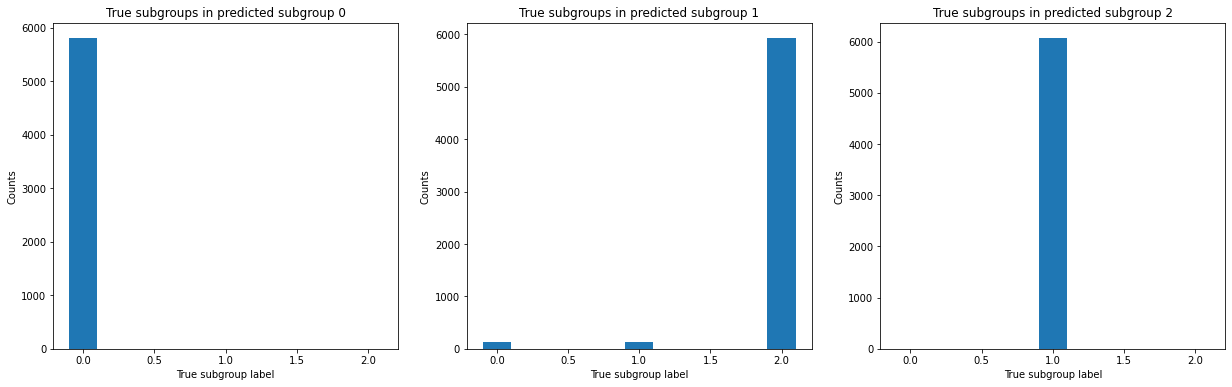

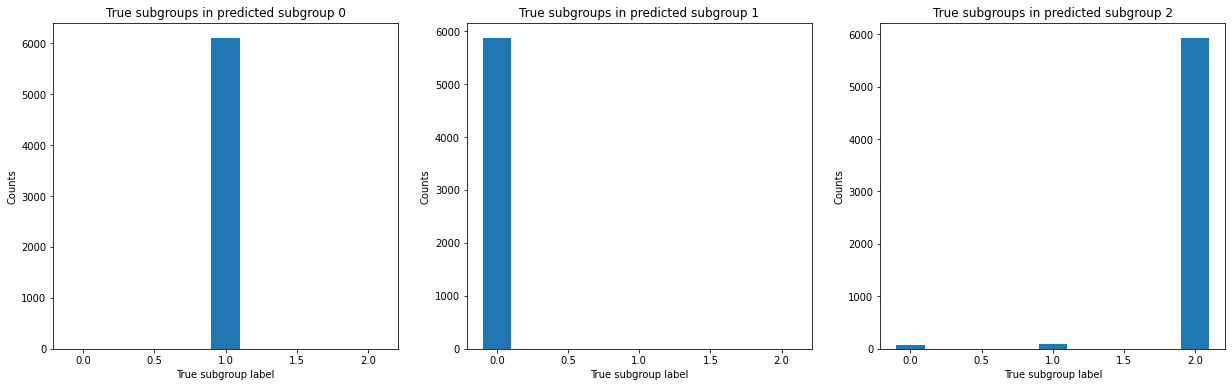

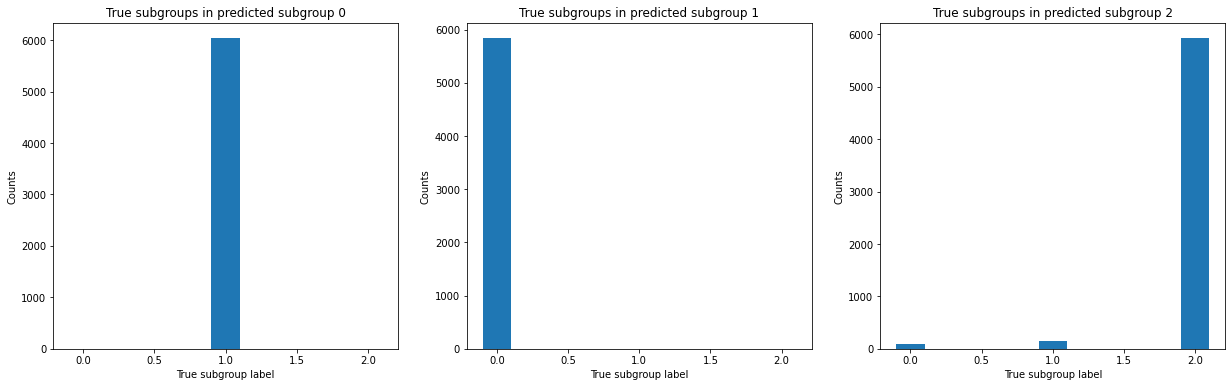

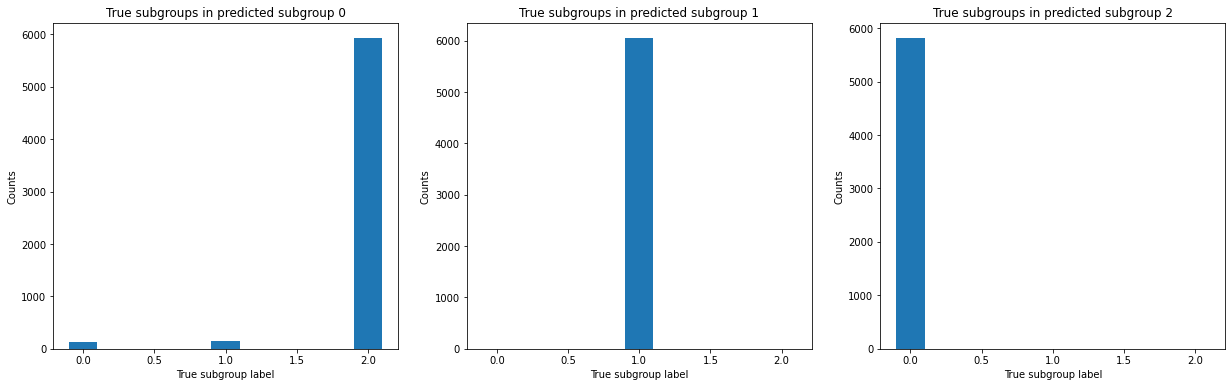

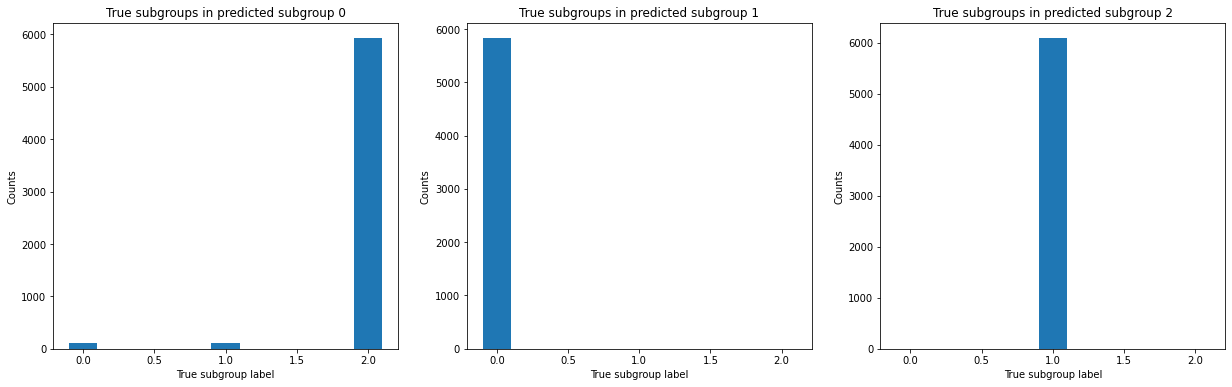

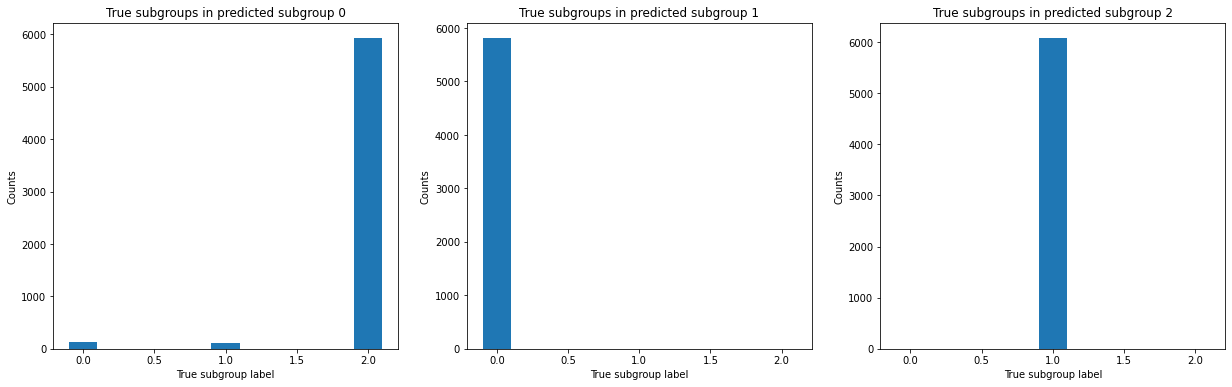

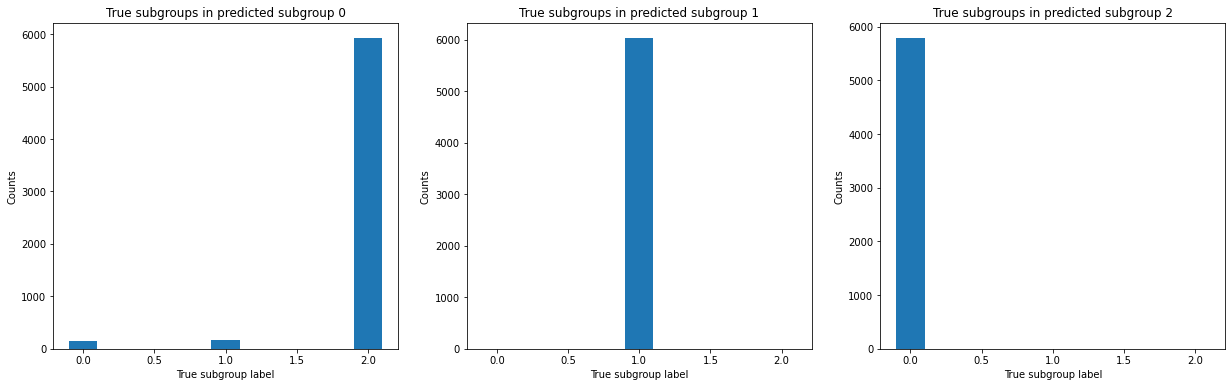

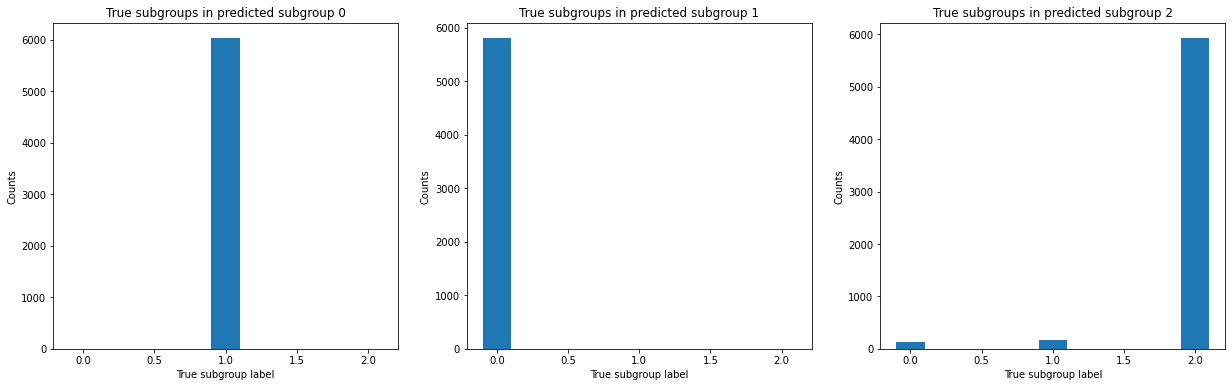

In [19]:
plot_hist_subgroups(n_runs=10, num_subgroups=3, dataset=cmnist_tr, indices=results['idx_tr'], probs=results['probs_tr'], check_bp=True)

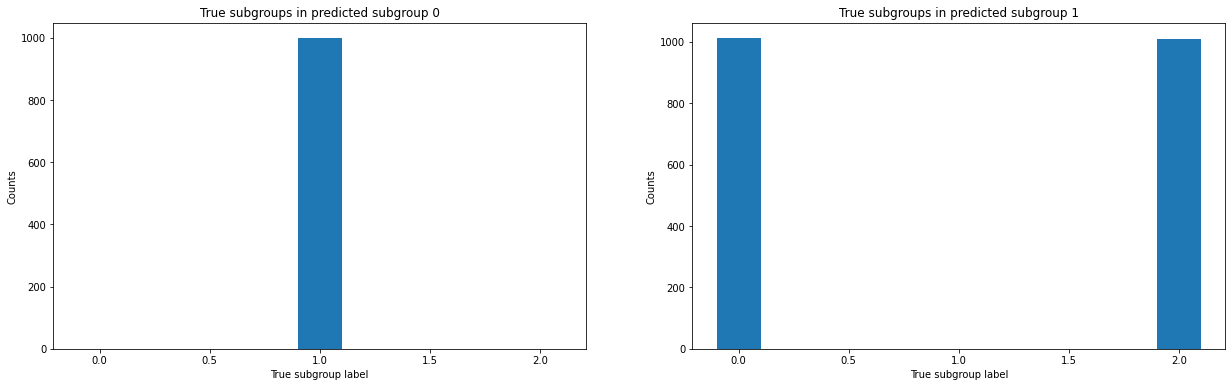

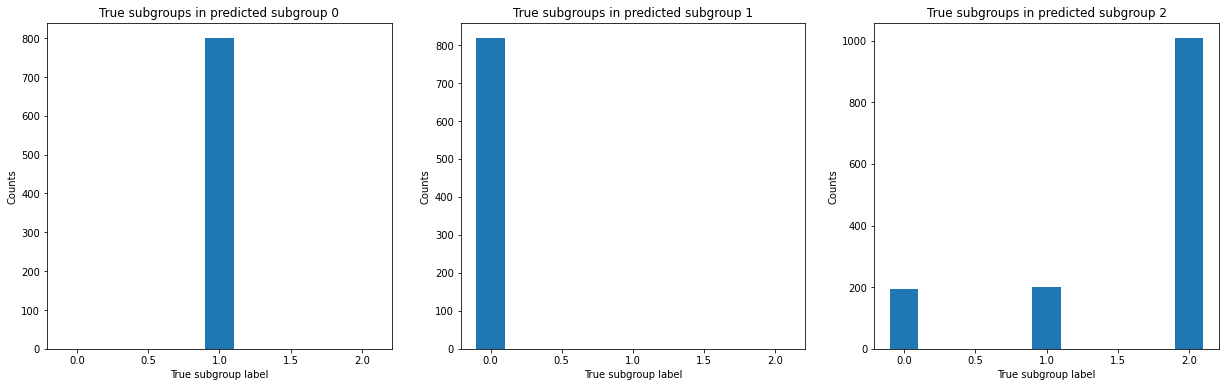

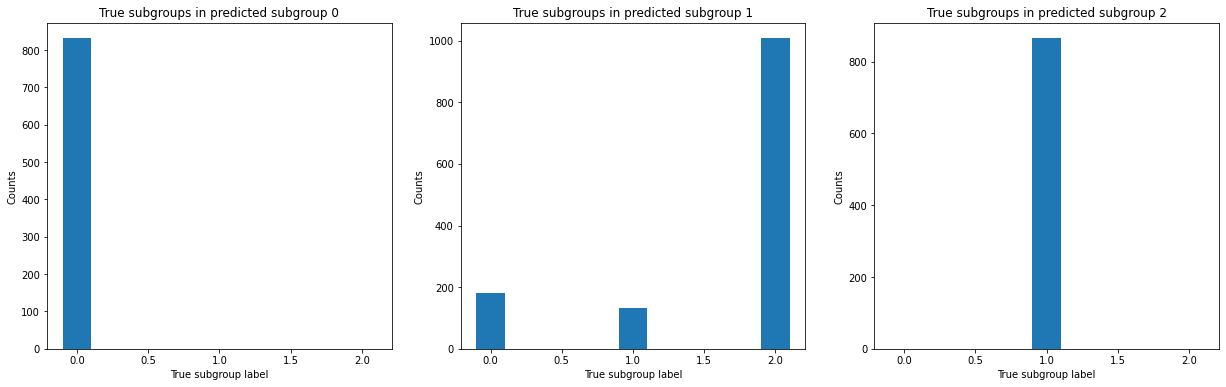

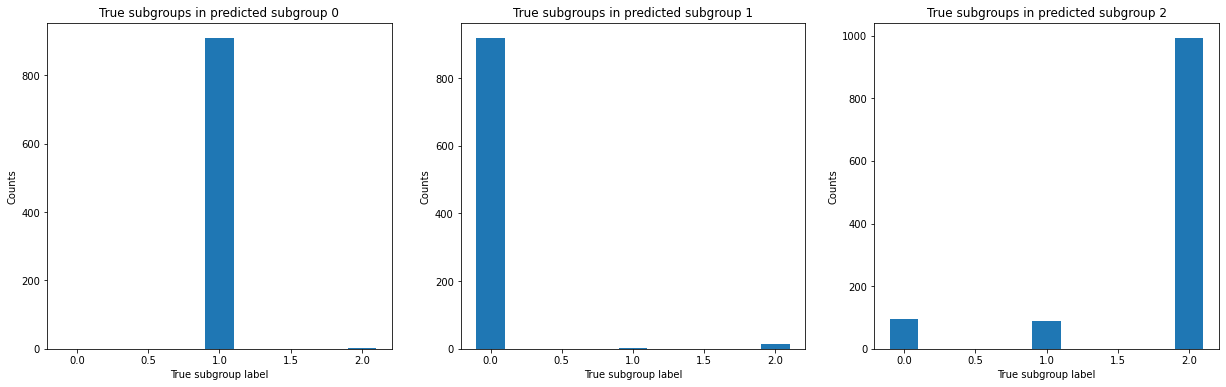

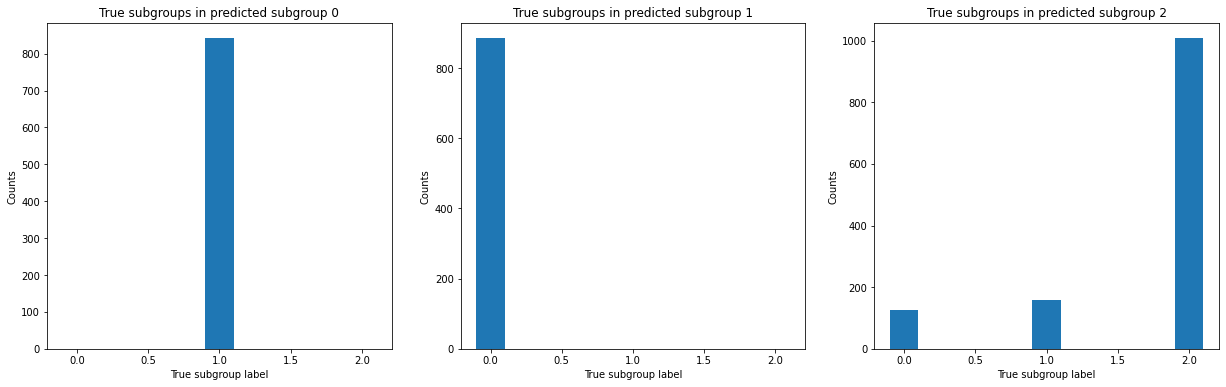

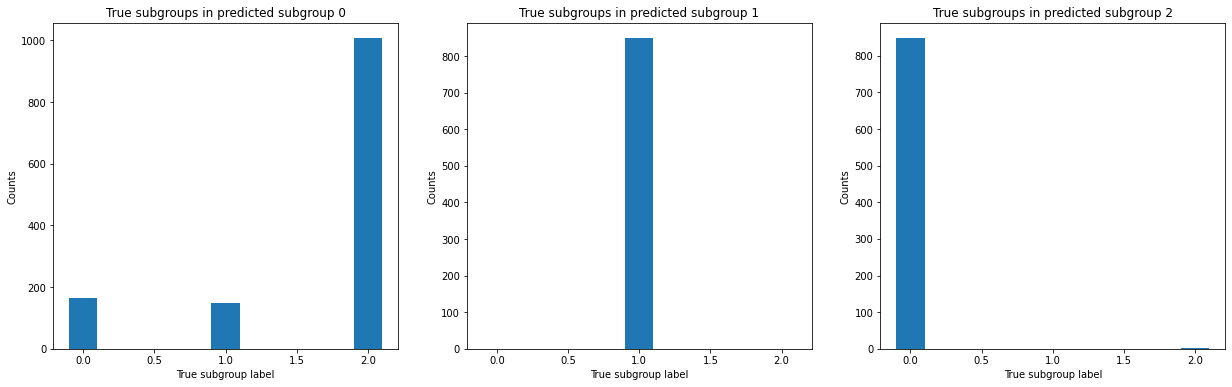

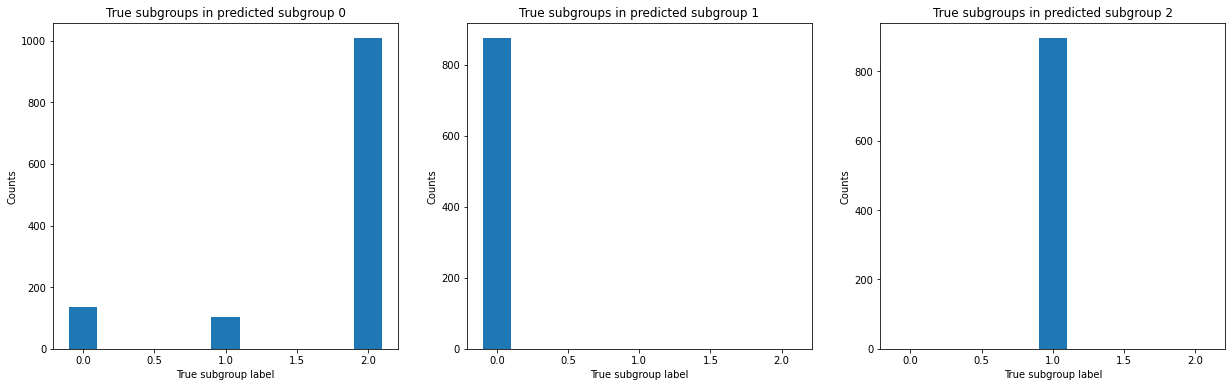

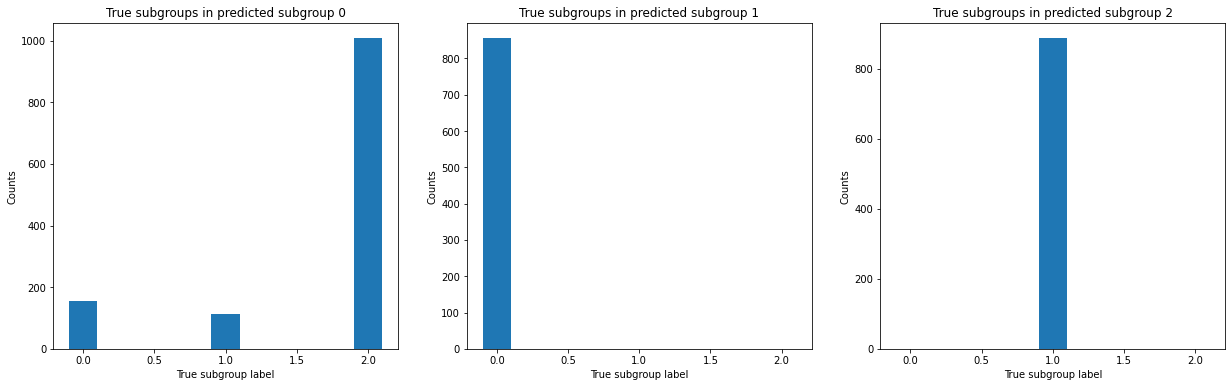

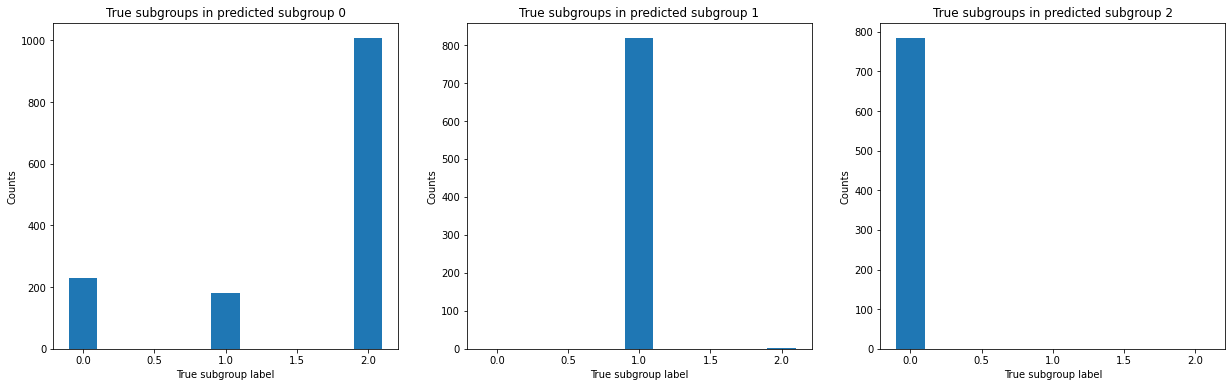

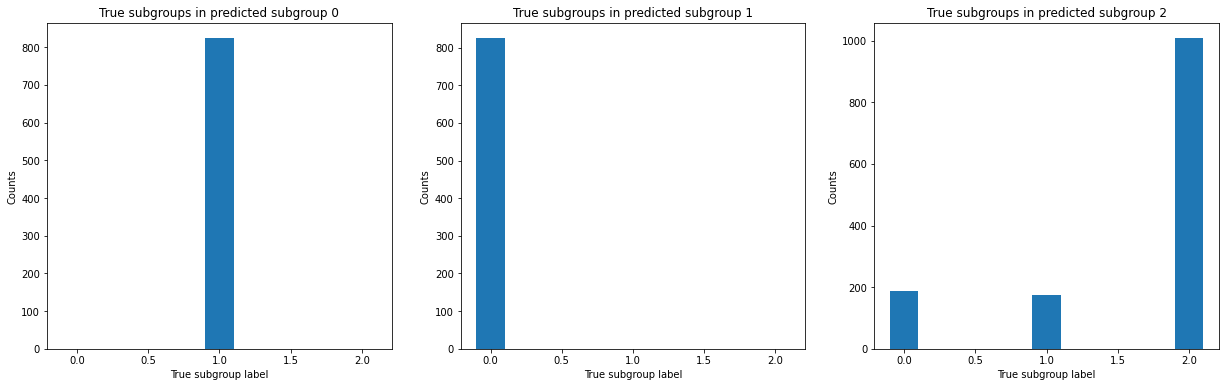

In [20]:
plot_hist_subgroups(n_runs=10, num_subgroups=3, dataset=cmnist_te, indices=results['idx_te'], probs=results['probs_te'], check_bp=False)

In [33]:
#without adversary+MI, for each class take minimum gap among subgroups - not expressive enough ?
# larger batch sizes don't seem to help
model = MLP(n_layers=3, input_dim=3*14*14, hidden_dim=256, output_dim=3)
results = n_runs_subgroupNoAdv(n_runs=10, n_epochs=30, num_classes=3, num_subgroups=3, dataset_tr=cmnist_tr, dataset_te=cmnist_te,
                               lr=0.001, loss_fn=DemographicParityGap(agg='min_sg'), train_loader=train_loader, test_loader=test_loader, 
                               device=device, model=model)

--------Run 0--------
Train homogeneity score: 0.548 ; Train completeness score: 0.928
Test homogeneity score: 0.439 ; Test completeness score: 0.714
--------Run 1--------
Train homogeneity score: 0.577 ; Train completeness score: 1.000
Test homogeneity score: 0.581 ; Test completeness score: 1.000
--------Run 2--------
Train homogeneity score: 0.577 ; Train completeness score: 1.000
Test homogeneity score: 0.581 ; Test completeness score: 1.000
--------Run 3--------
Train homogeneity score: 0.583 ; Train completeness score: 0.995
Test homogeneity score: 0.571 ; Test completeness score: 0.986
--------Run 4--------
Train homogeneity score: 0.000 ; Train completeness score: 1.000
Test homogeneity score: 0.000 ; Test completeness score: 1.000
--------Run 5--------
Train homogeneity score: 0.572 ; Train completeness score: 0.975
Test homogeneity score: 0.527 ; Test completeness score: 0.898
--------Run 6--------
Train homogeneity score: 0.533 ; Train completeness score: 0.922
Test homogene

## Subgroup Label Prediction with MI regularizer

In [17]:
BATCH_SIZE = 512
train_loader = torch.utils.data.DataLoader(cmnist_tr,batch_size=BATCH_SIZE,shuffle=True,num_workers=0) 

In [18]:
# batchsize=512
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learner = MLP(n_layers=3, input_dim=3*14*14, hidden_dim=64, output_dim=3)
adv = MLP(n_layers=1, input_dim=64, hidden_dim=64, output_dim=3)
results = n_runs_subgroupAdvTrain_v2(n_runs=10, n_epochs=30, dataset_tr=cmnist_tr, dataset_te=cmnist_te, device=device, 
                                     num_classes=3, num_subgroups=3, train_loader=train_loader, test_loader=test_loader,
                                     model_learner=learner, model_adv=adv, loss_fn_learner=DemographicParityGap(),
                                     lr=0.01, lr_adv=0.001, mi_weight=1.0, anomaly_detection=False)

--------Run 0--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Adversary train accuracy (target=biased predictions): 0.98560
--------Run 1--------
Train homogeneity score: 0.217 ; Train completeness score: 0.509
Test homogeneity score: 0.029 ; Test completeness score: 0.242
Adversary train accuracy (target=biased predictions): 0.65568
--------Run 2--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Adversary train accuracy (target=biased predictions): 0.98554
--------Run 3--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 0.996 ; Test completeness score: 0.996
Adversary train accuracy (target=biased predictions): 0.98532
--------Run 4--------
Train homogeneity score: 0.354 ; Train completeness score: 0.686
Test homogeneity score: 0.114 ; Test completeness score: 0.371
Ad

In [27]:
with open('../results/cmnist_3_3_dpg.pkl', 'wb') as f:
  pkl.dump(results, f)

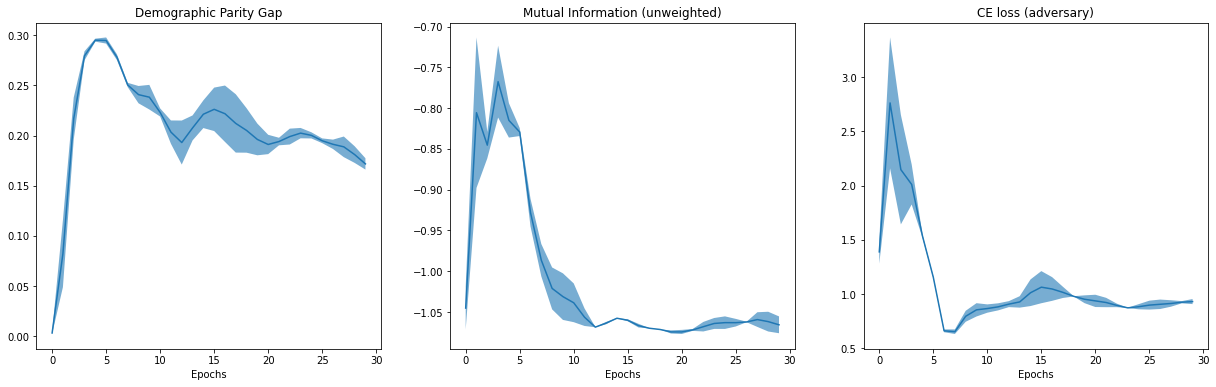

In [25]:
plot_subgroup_losses(results['epoch_loss'], results['epoch_mi'], results['epoch_loss_adv'], runs=[1,4])

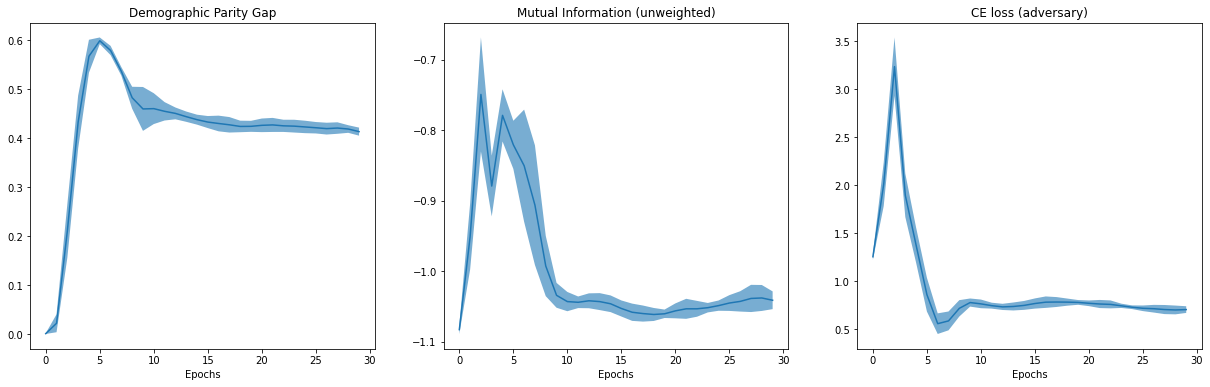

In [26]:
plot_subgroup_losses(results['epoch_loss'], results['epoch_mi'], results['epoch_loss_adv'], runs=[0,2,3,5,6,7,8,9])

acc_biased_preds
label subgroup                  
0     0                 0.999431
      1                 0.670103
      2                 0.989362
1     0                 0.677419
      1                 0.993960
      2                 0.990798
2     0                 0.972050
      1                 0.960000
      2                 0.999813

acc_biased_preds
label subgroup                  
0     0                 0.999431
      1                 0.670103
      2                 0.989362
1     0                 0.677419
      1                 0.993960
      2                 0.990798
2     0                 0.972050
      1                 0.960000
      2                 0.999813

acc_biased_preds
label subgroup                  
0     0                 0.999431
      1                 0.670103
      2                 0.989362
1     0                 0.677419
      1                 0.993960
      2                 0.990798
2     0                 0.972050
      1                 0.960000
      2                 0.999813

acc_biased_preds
label subgroup                  
0     0                 0.999431
      1                 0.670103
      2                 0.989362
1     0                 0.677419
      1                 0.993960
      2                 0.990798
2     0                 0.972050
      1                 0.960000
      2                 0.999813

acc_biased_preds
label subgroup                  
0     0                 0.999431
      1                 0.670103
      2                 0.989362
1     0                 0.680645
      1                 0.994138
      2                 0.990798
2     0                 0.972050
      1                 0.960000
      2                 0.999813

acc_biased_preds
label subgroup                  
0     0                 0.999241
      1                 0.670103
      2                 0.989362
1     0                 0.677419
      1                 0.993960
      2                 0.990798
2     0                 0.972050
      1                 0.960000
      2                 0.999813

acc_biased_preds
label subgroup                  
0     0                 0.999431
      1                 0.670103
      2                 0.989362
1     0                 0.677419
      1                 0.993960
      2                 0.990798
2     0                 0.972050
      1                 0.960000
      2                 0.999813

acc_biased_preds
label subgroup                  
0     0                 0.999431
      1                 0.670103
      2                 0.989362
1     0                 0.677419
      1                 0.993960
      2                 0.990798
2     0                 0.972050
      1                 0.960000
      2                 0.999813

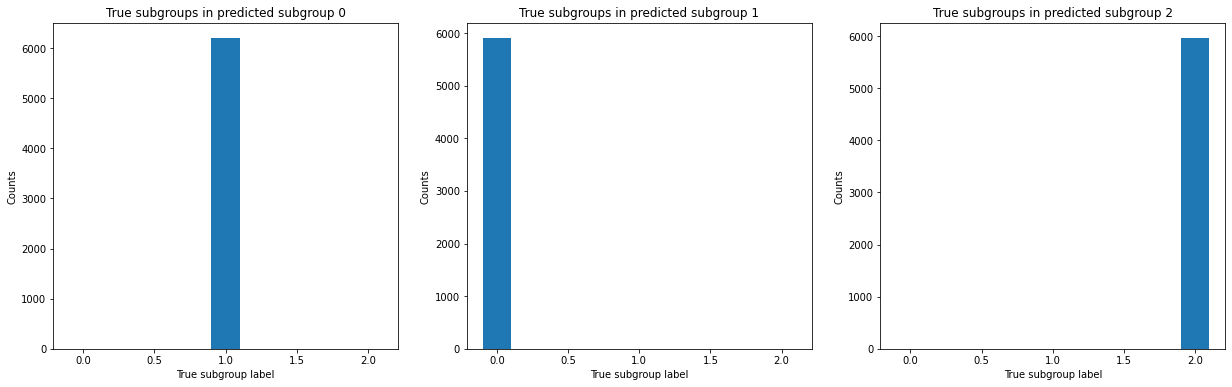

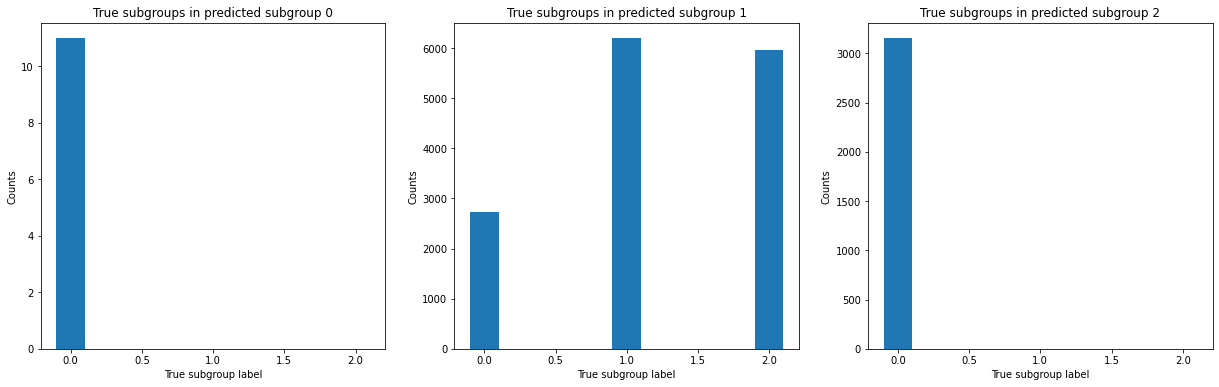

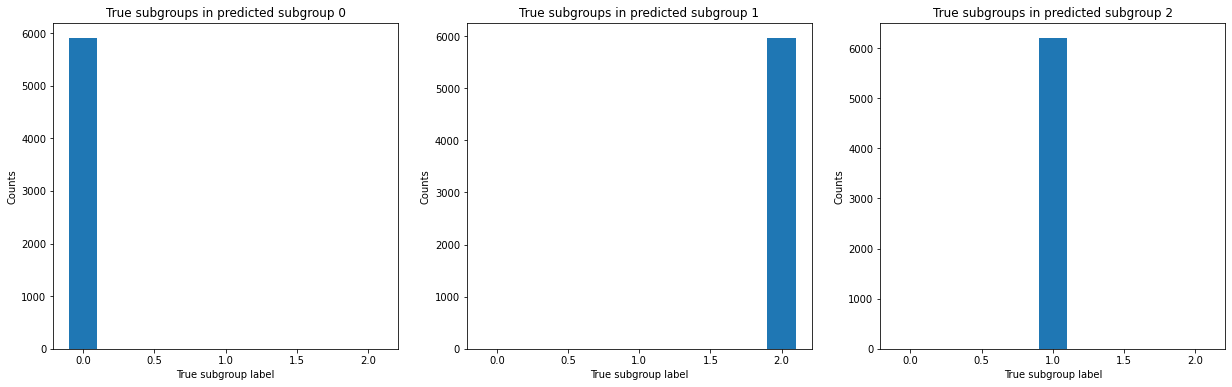

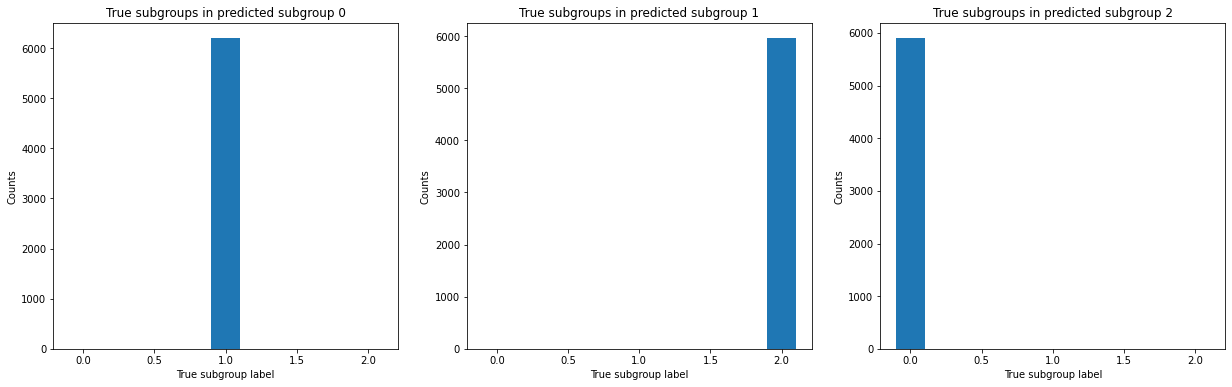

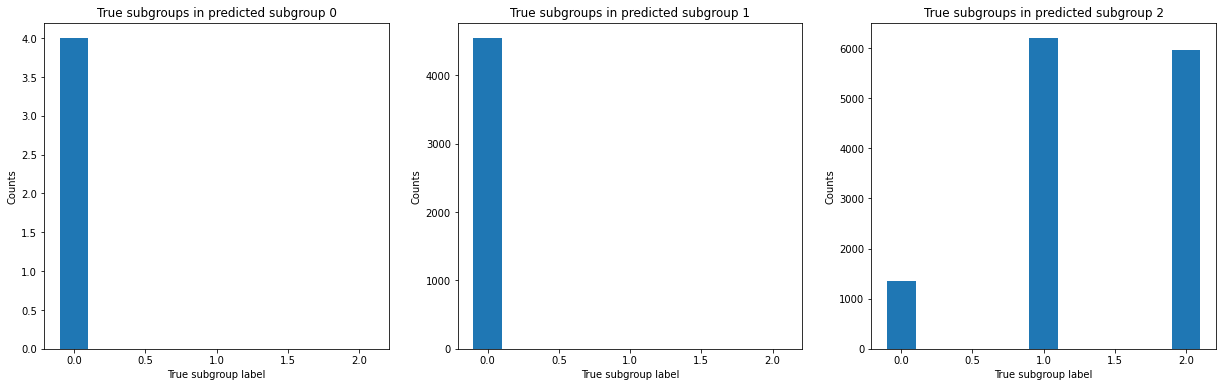

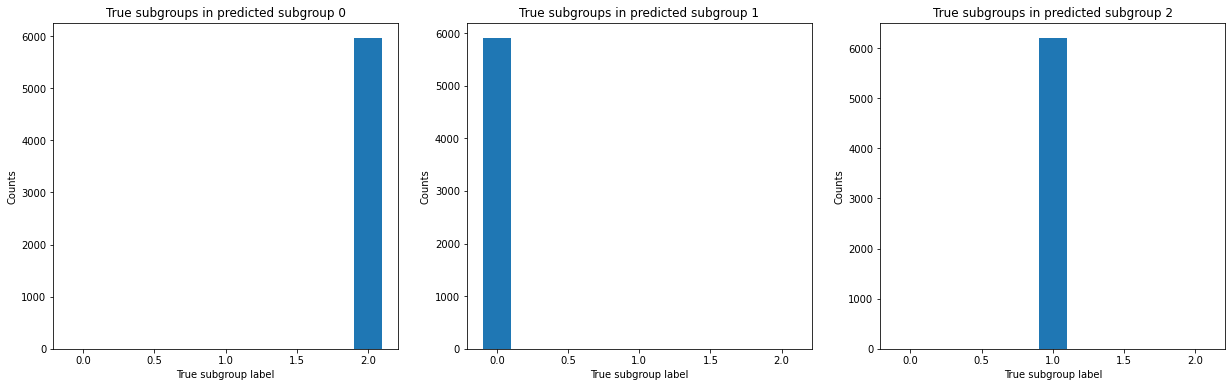

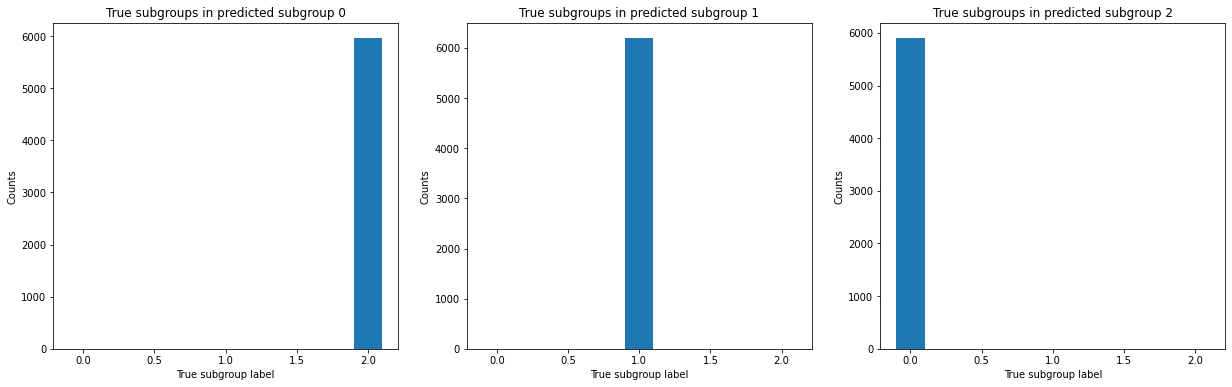

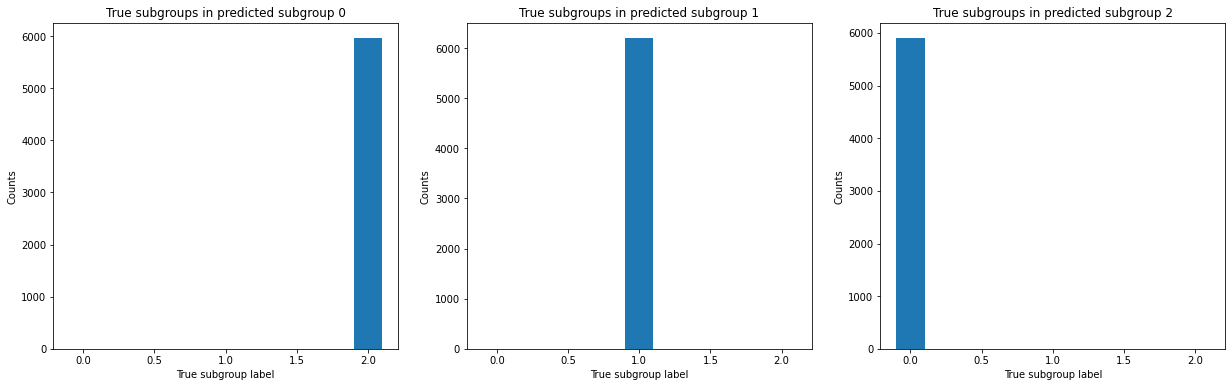

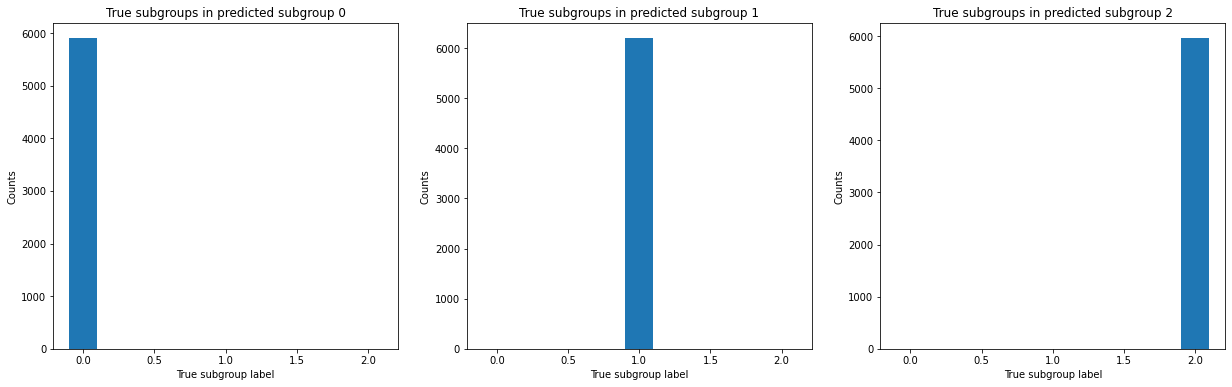

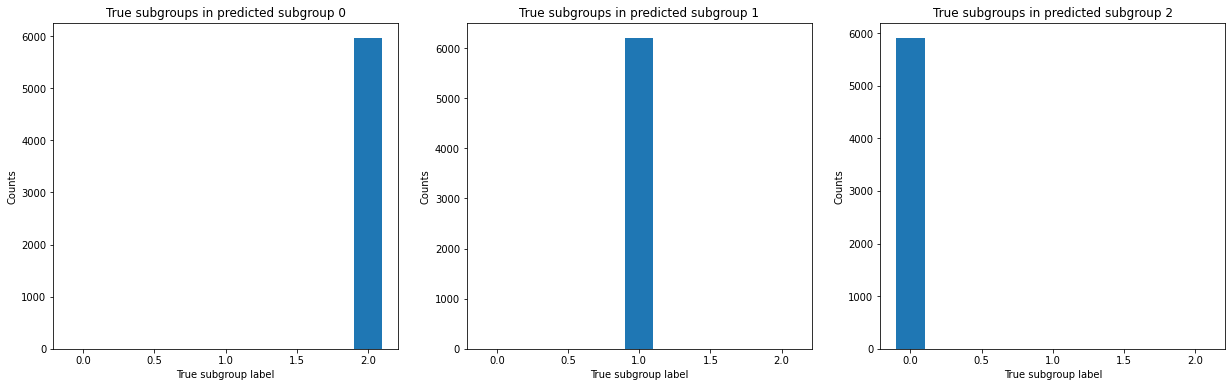

In [22]:
plot_hist_subgroups(n_runs=10, num_subgroups=3, dataset=cmnist_tr, indices=results['idx_tr'], probs=results['probs_tr'], check_bp=True)

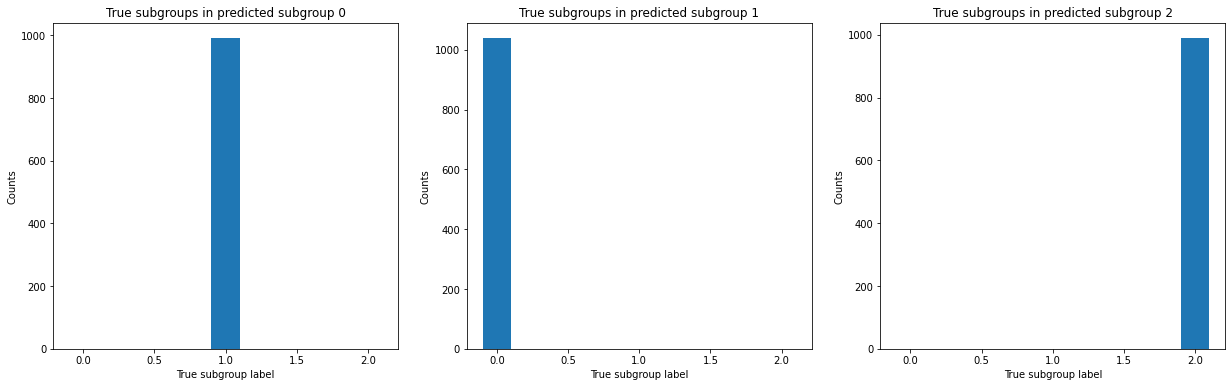

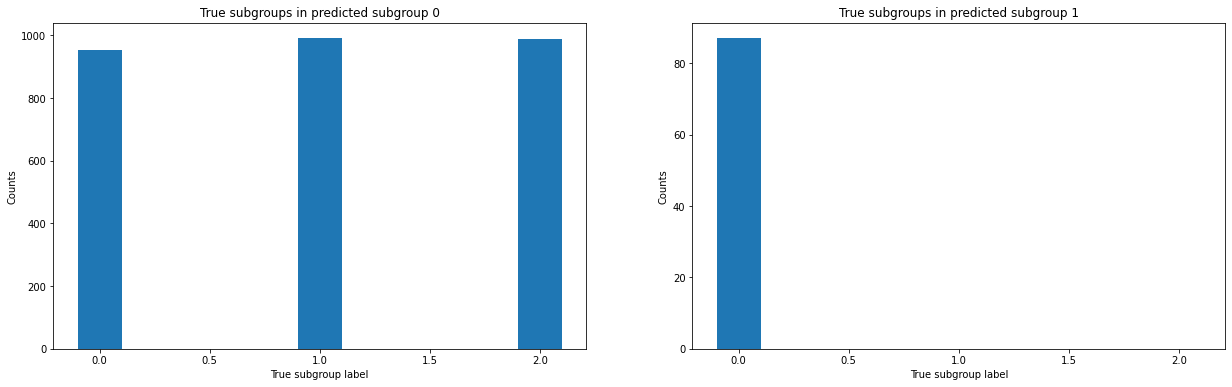

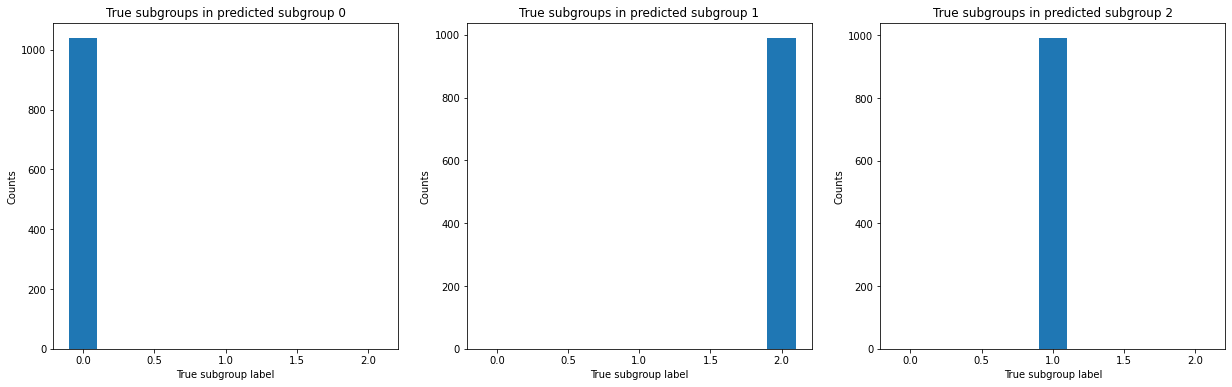

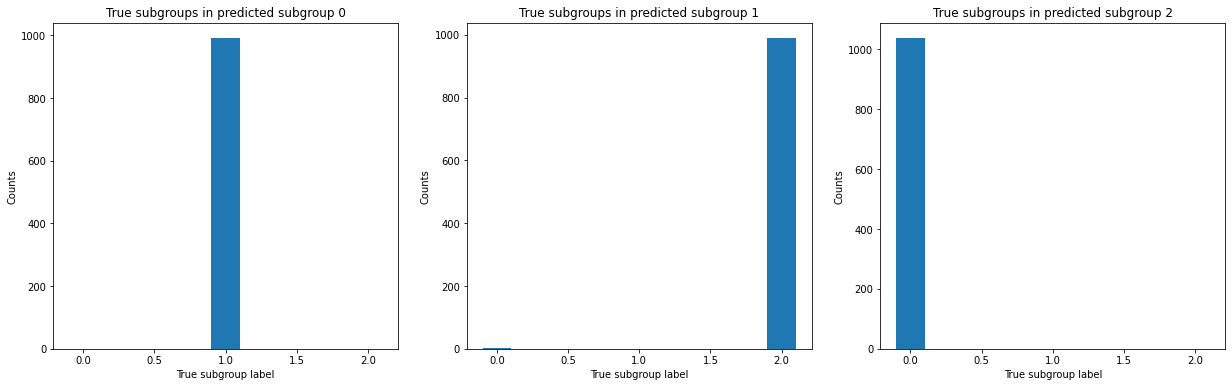

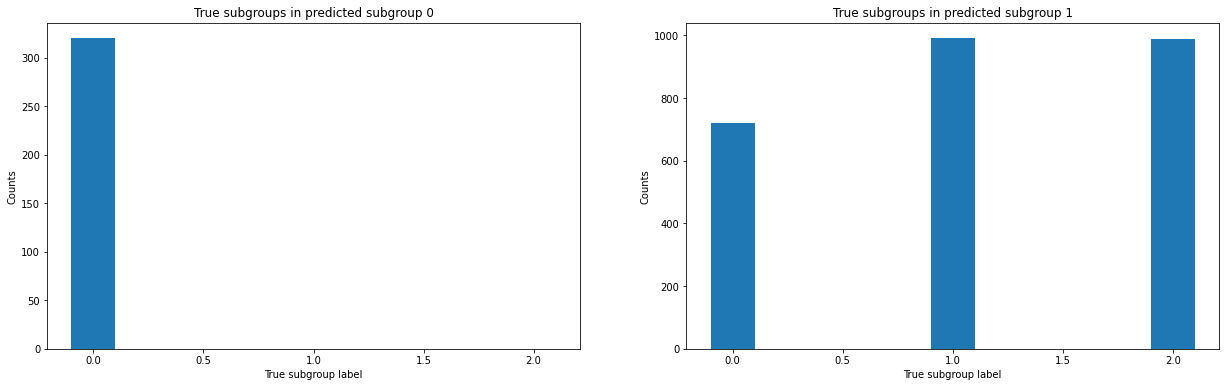

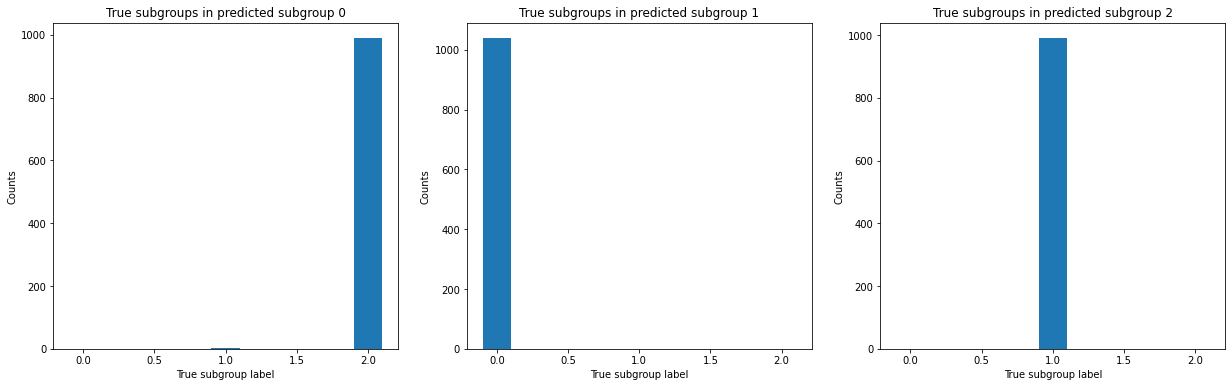

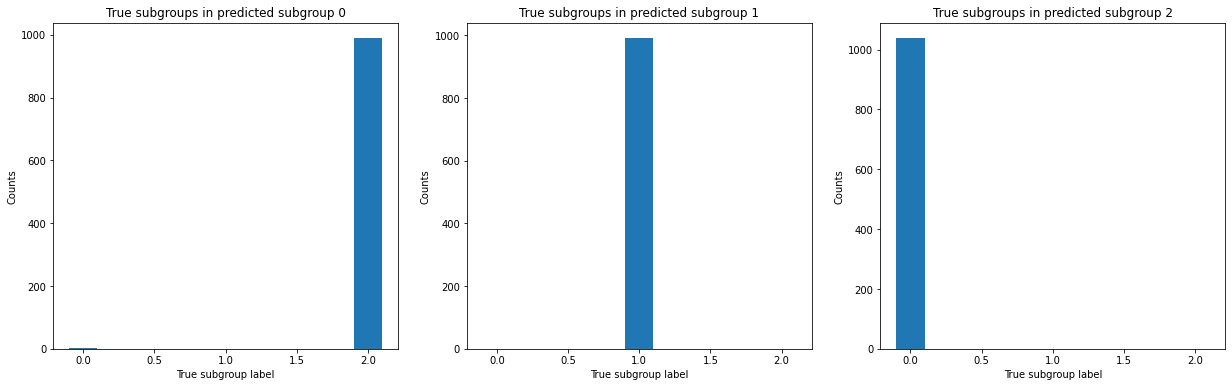

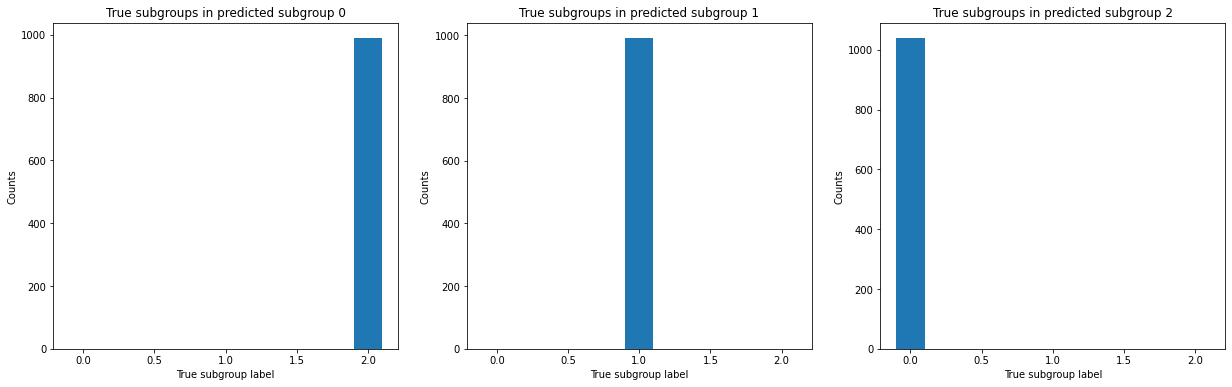

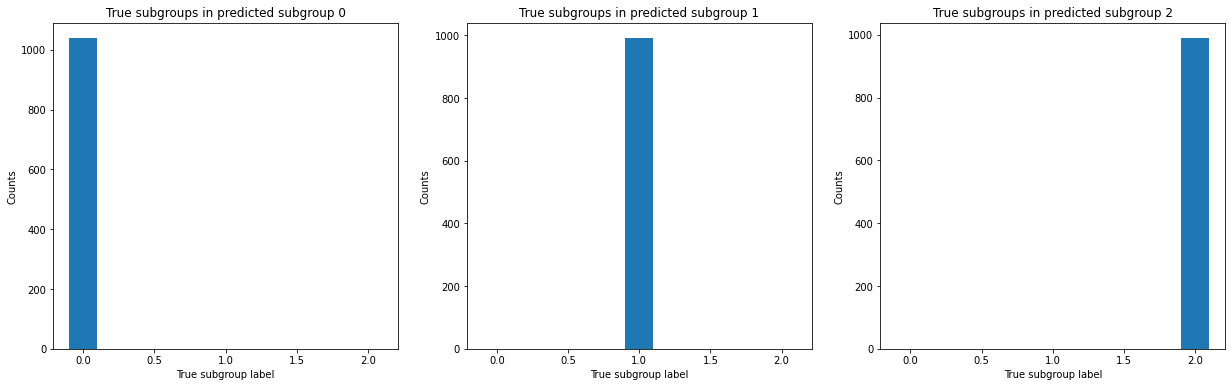

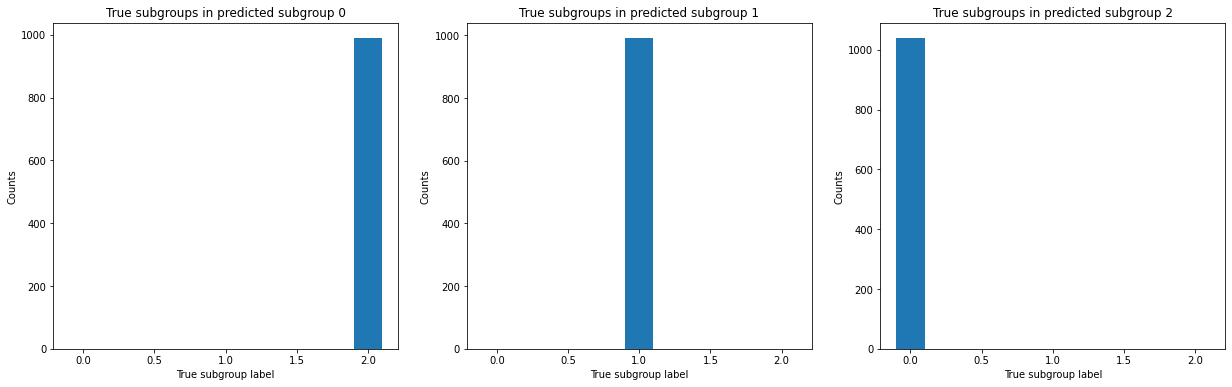

In [23]:
plot_hist_subgroups(n_runs=10, num_subgroups=3, dataset=cmnist_te, indices=results['idx_te'], probs=results['probs_te'], check_bp=False)

# Reduced CMNIST: 10 classes (digits), 2 subgroups (colors)

In [7]:
BATCH_SIZE = 4096 
cmnist_tr = CustomDatasetCMNIST(train=True, main_color_prop=0.95, class_colors=[0]*5 + [1]*5, classes=list(range(10)))
train_loader = torch.utils.data.DataLoader(cmnist_tr,batch_size=BATCH_SIZE,shuffle=True,num_workers=0) 
cmnist_te = CustomDatasetCMNIST(train=False, main_color_prop=0.1, class_colors=[0]*5 + [1]*5, classes=list(range(10)), means=cmnist_tr.means, stds=cmnist_tr.stds)
test_loader = torch.utils.data.DataLoader(cmnist_te,batch_size=BATCH_SIZE,shuffle=True,num_workers=0)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# reference classifier
ref_clf = MLP(n_layers=3, input_dim=3*14*14, hidden_dim=256, output_dim=10).to(device)
optimizer_ref = optim.SGD(ref_clf.parameters(), lr=0.05)
n_epochs = 5

ref_clf, loss = train_reference(ref_clf, train_loader, optimizer_ref, nn.CrossEntropyLoss(), n_epochs, device)

Epoch 0: loss=2.16616
Epoch 4: loss=0.59003


Train set
Average accuracy: 0.87333


accuracy
label subgroup          
0     0         0.958503
      1         0.049296
1     0         0.976120
      1         0.405970
2     0         0.871899
      1         0.003185
3     0         0.903926
      1         0.000000
4     0         0.966026
      1         0.000000
5     0         0.000000
      1         0.787832
6     0         0.000000
      1         0.961272
7     0         0.321656
      1         0.907747
8     0         0.000000
      1         0.906633
9     0         0.000000
      1         0.893696

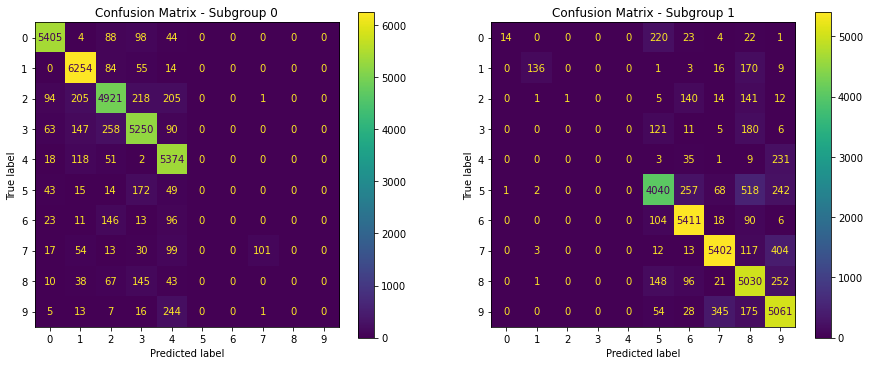

In [9]:
print('Train set')
df, confs = test_reference(ref_clf, train_loader, device)
display(df)
print()
display_confs(confs)

Test set
Average accuracy: 0.16800


accuracy
label subgroup          
0     0         0.956522
      1         0.083333
1     0         0.991870
      1         0.416008
2     0         0.861386
      1         0.000000
3     0         0.920792
      1         0.000000
4     0         0.980769
      1         0.000000
5     0         0.000000
      1         0.777778
6     0         0.000000
      1         0.954023
7     0         0.324353
      1         0.880000
8     0         0.000000
      1         0.958904
9     0         0.000000
      1         0.916667

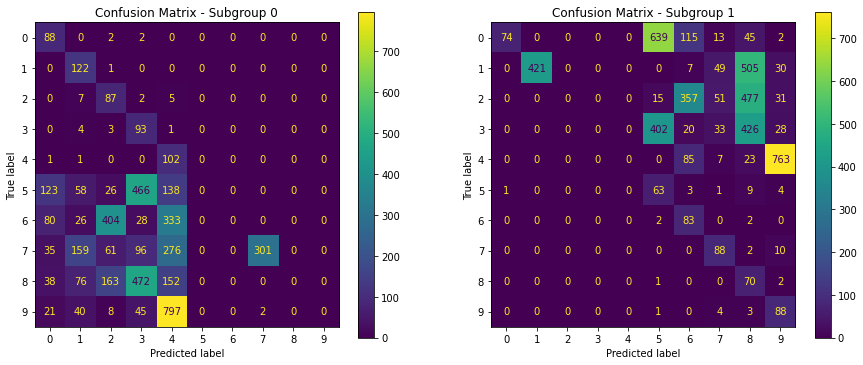

In [10]:
print('Test set')
df, confs = test_reference(ref_clf, test_loader, device)
display(df)
print()
display_confs(confs)

In [11]:
# get biased preds -
# funk it
for i in range(cmnist_tr.__len__()):
   _, img, _, _, _ = cmnist_tr.__getitem__(i)
   img = img.to(device)
   out, _ = ref_clf(img[None, :, :, :])
   out = nn.Softmax(dim=-1)(out)
   cmnist_tr.biased_predictions[i] = torch.argmax(out, dim=1).cpu().item()

In [10]:
# check demographic parity gap for true subgroups
num_classes=10
num_subgroups=2
out = nn.functional.one_hot(cmnist_tr.subgroup).float()
biased_preds = cmnist_tr.biased_predictions.long()

-DemographicParityGap(print_gaps=True)(out, biased_preds, None, num_classes, num_subgroups, torch.device('cpu'))

tensor([[0.0347],
        [0.0495],
        [0.0327],
        [0.0392],
        [0.0417],
        [0.0298],
        [0.0406],
        [0.0395],
        [0.0446],
        [0.0432]])


tensor(0.0396)

In [11]:
# check demographic parity gap for subgroups based on biased_preds
num_classes=10
num_subgroups=2
out = nn.functional.one_hot(cmnist_tr.biased_predictions.long()).float()
biased_preds = cmnist_tr.biased_predictions.long()

-DemographicParityGap(print_gaps=True)(out, biased_preds, None, num_classes, num_subgroups, torch.device('cpu'))

tensor([[1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])


tensor(0.2000)

In [12]:
# check eq odds gap for true subgroups
num_classes=10
num_subgroups=2
out = nn.functional.one_hot(cmnist_tr.subgroup).float()
biased_preds = cmnist_tr.biased_predictions.long()

-EqualizedOddsGap(print_gaps=True)(out, biased_preds, cmnist_tr.label, num_classes, num_subgroups, torch.device('cpu'))

tensor([[0.9124],
        [0.3487],
        [0.6983],
        [0.8323],
        [0.9292],
        [0.6925],
        [0.9026],
        [0.4001],
        [0.8204],
        [0.7969]])


tensor(0.7333)

In [13]:
# check eq odds gap based on bp
num_classes=10
num_subgroups=2
out = nn.functional.one_hot(cmnist_tr.biased_predictions.long()).float()
biased_preds = cmnist_tr.biased_predictions.long()

-EqualizedOddsGap(print_gaps=True)(out, biased_preds, cmnist_tr.label, num_classes, num_subgroups, torch.device('cpu'))

tensor([[1.],
        [nan],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])


tensor(nan)

In [13]:
BATCH_SIZE = 512
train_loader = torch.utils.data.DataLoader(cmnist_tr,batch_size=BATCH_SIZE,shuffle=True,num_workers=0) 

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
learner = MLP(n_layers=3, input_dim=3*14*14, hidden_dim=64, output_dim=2)
adv = MLP(n_layers=1, input_dim=64, hidden_dim=64, output_dim=10)
results = n_runs_subgroupAdvTrain_v2(n_runs=10, n_epochs=10, dataset_tr=cmnist_tr, dataset_te=cmnist_te, device=device, 
                                     num_classes=10, num_subgroups=2, train_loader=train_loader, test_loader=test_loader,
                                     model_learner=learner, model_adv=adv, loss_fn_learner=EqualizedOddsGap(),
                                     lr=0.01, lr_adv=0.001, mi_weight=1.0, anomaly_detection=False)

--------Run 0--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Adversary train accuracy (target=biased predictions): 0.37603
--------Run 1--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Adversary train accuracy (target=biased predictions): 0.30630
--------Run 2--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Adversary train accuracy (target=biased predictions): 0.17410
--------Run 3--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Adversary train accuracy (target=biased predictions): 0.09453
--------Run 4--------
Train homogeneity score: 1.000 ; Train completeness score: 1.000
Test homogeneity score: 1.000 ; Test completeness score: 1.000
Ad

In [15]:
with open('../results/cmnist_10_2_eog.pkl', 'wb') as f:
  pkl.dump(results, f)

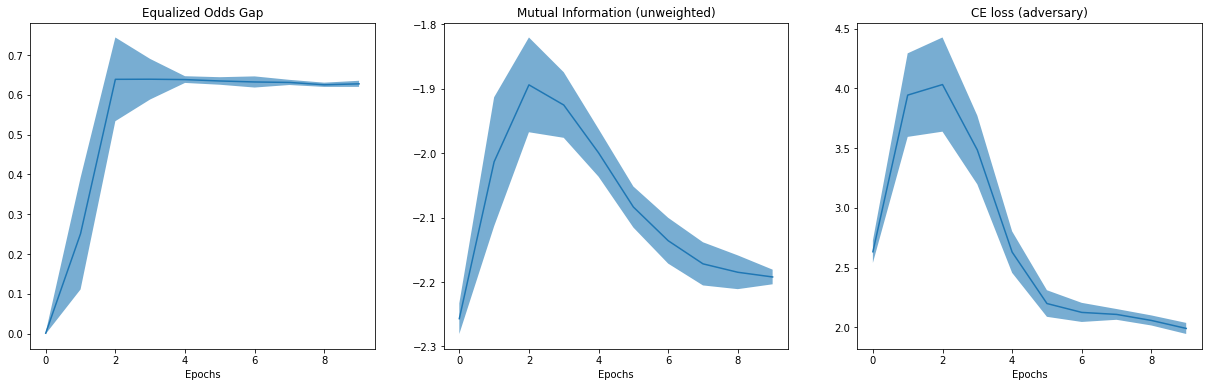

In [20]:
plot_subgroup_losses(results['epoch_loss'], results['epoch_mi'], results['epoch_loss_adv'], loss_name='Equalized Odds Gap')

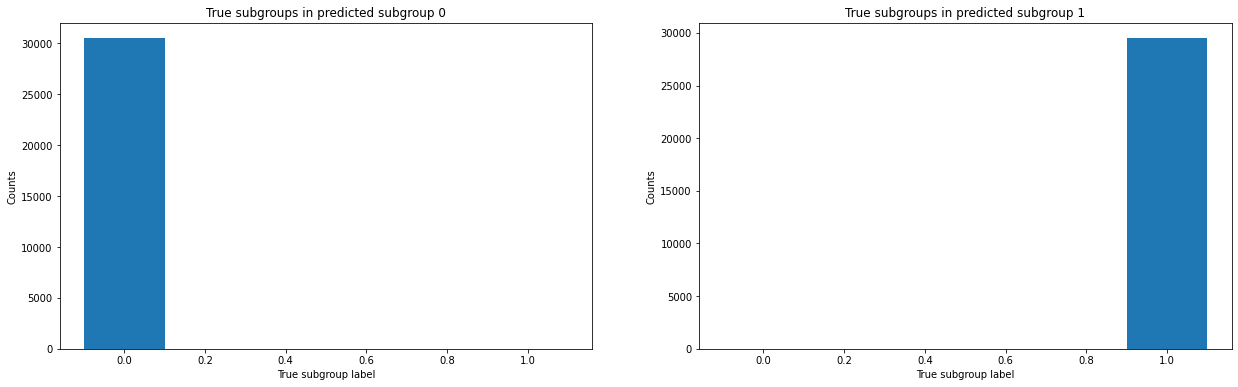

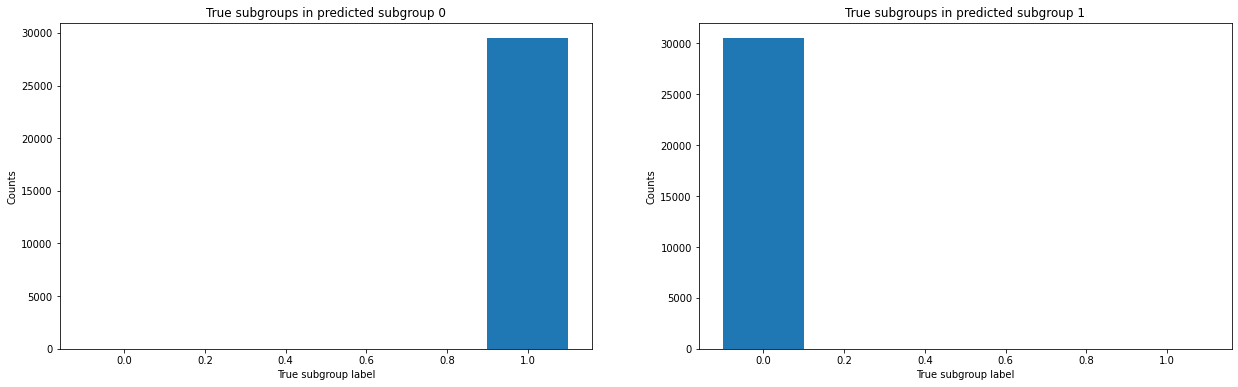

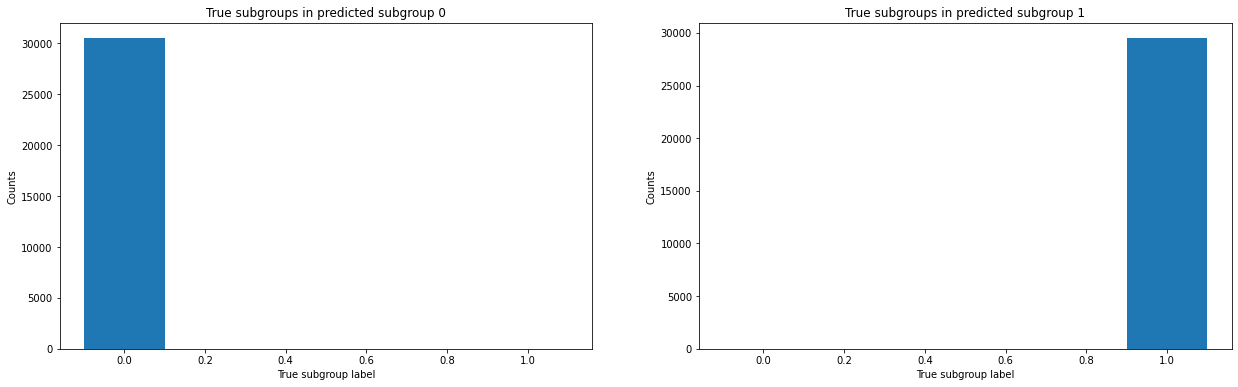

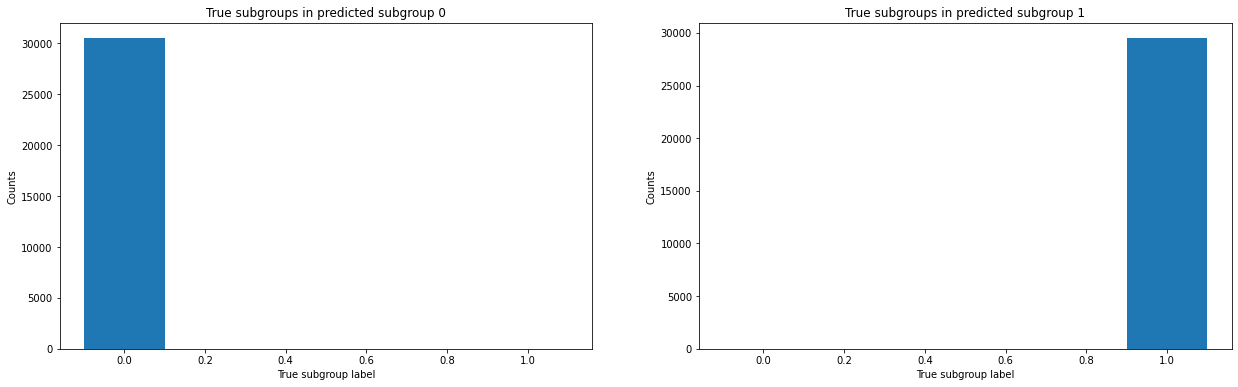

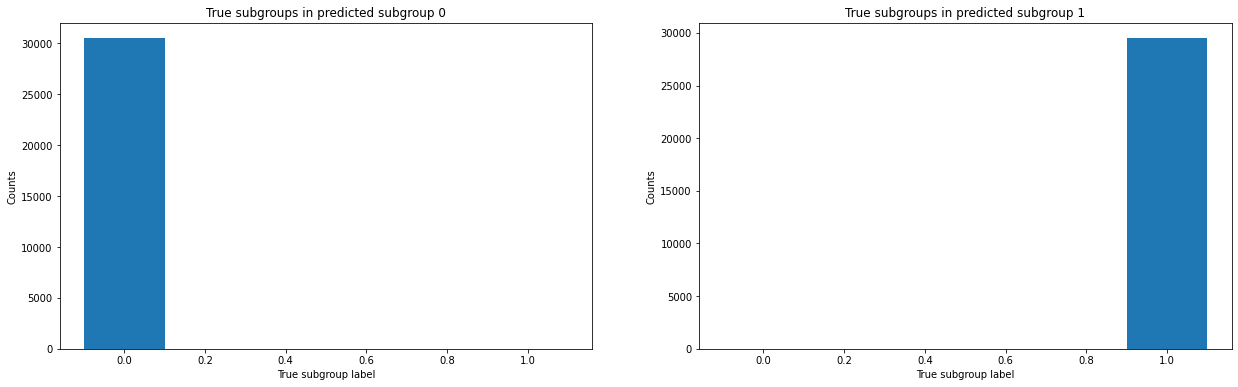

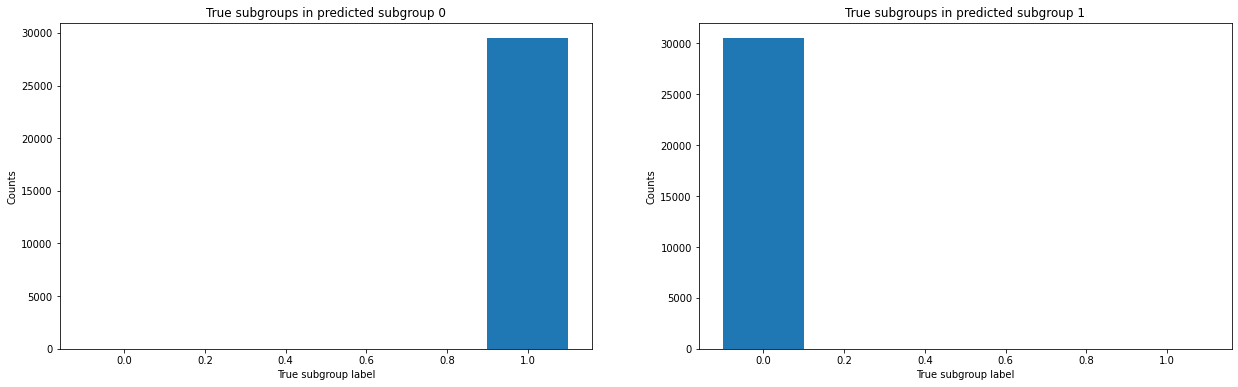

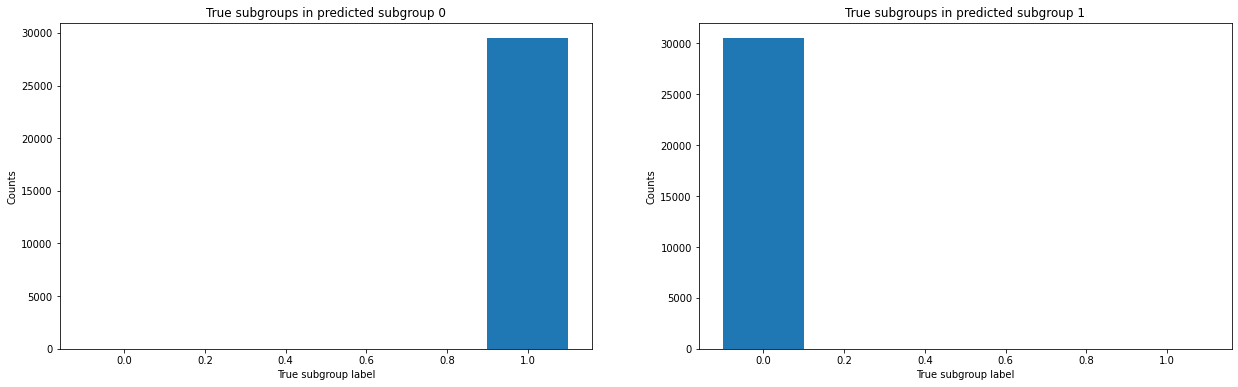

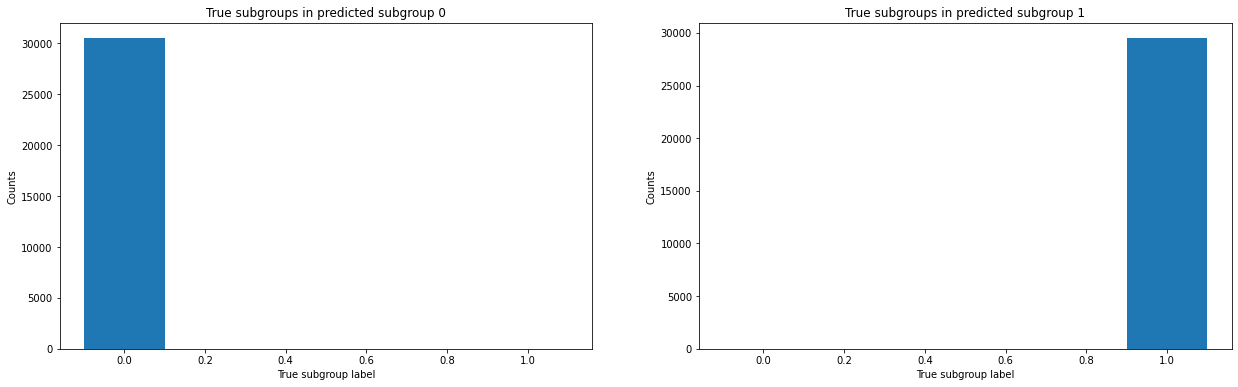

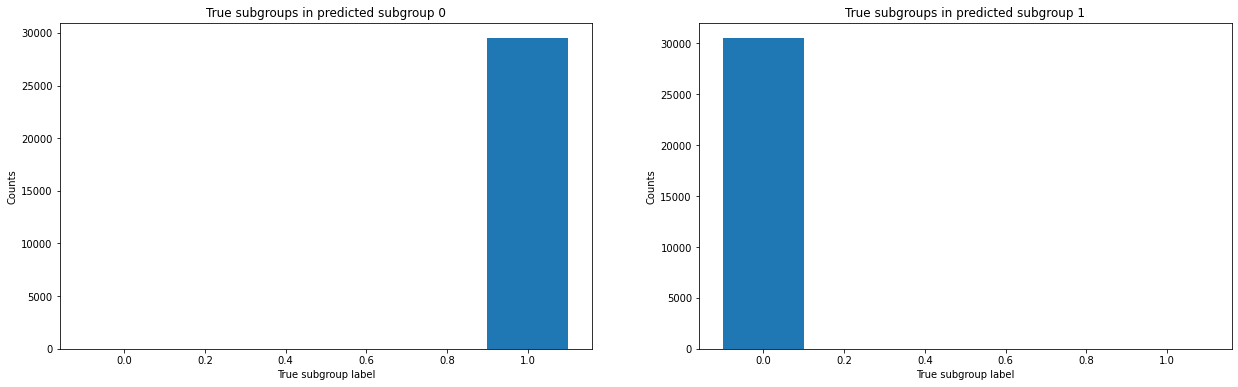

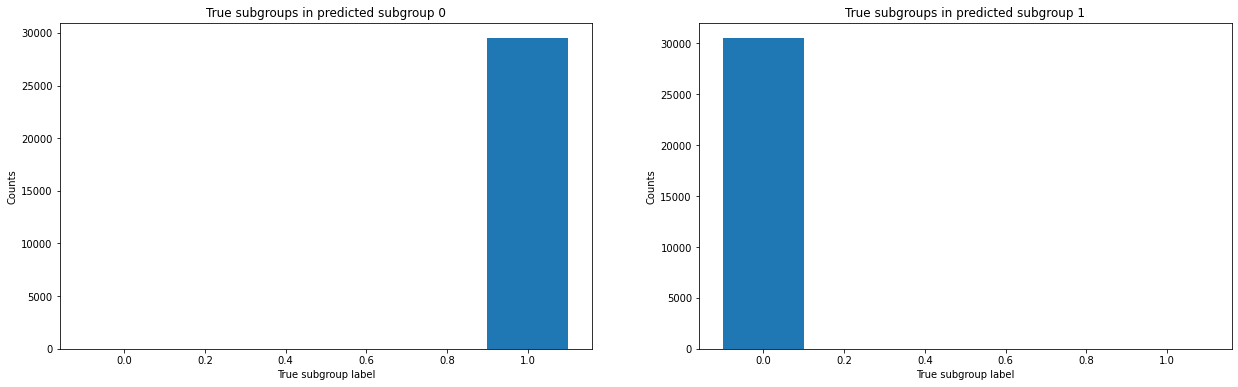

In [18]:
plot_hist_subgroups(n_runs=10, num_subgroups=2, dataset=cmnist_tr, indices=results['idx_tr'], probs=results['probs_tr'], check_bp=False)

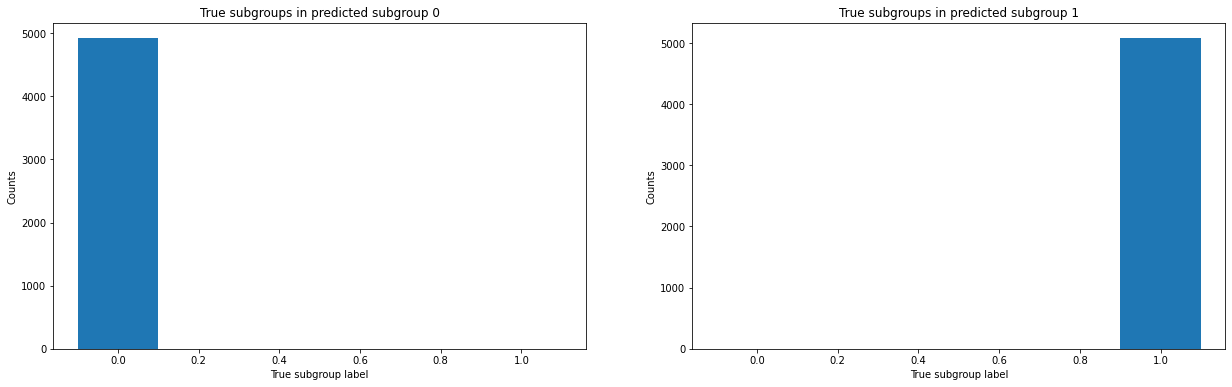

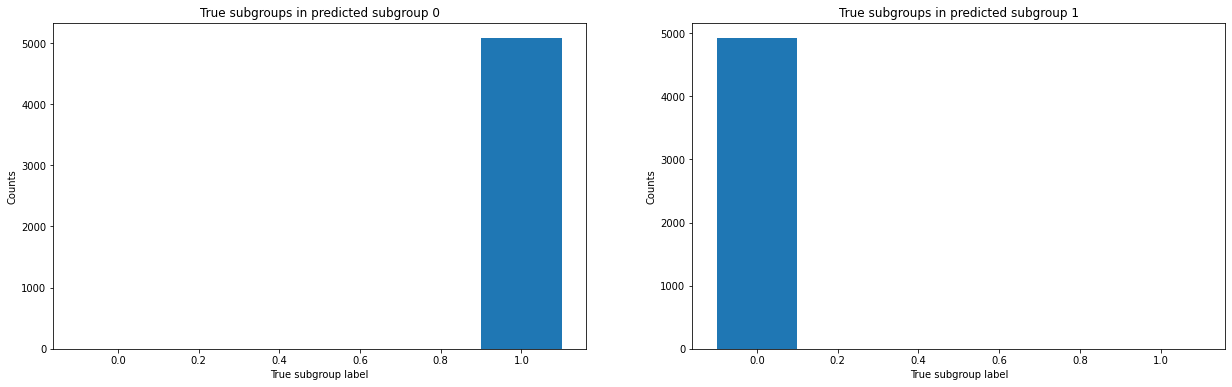

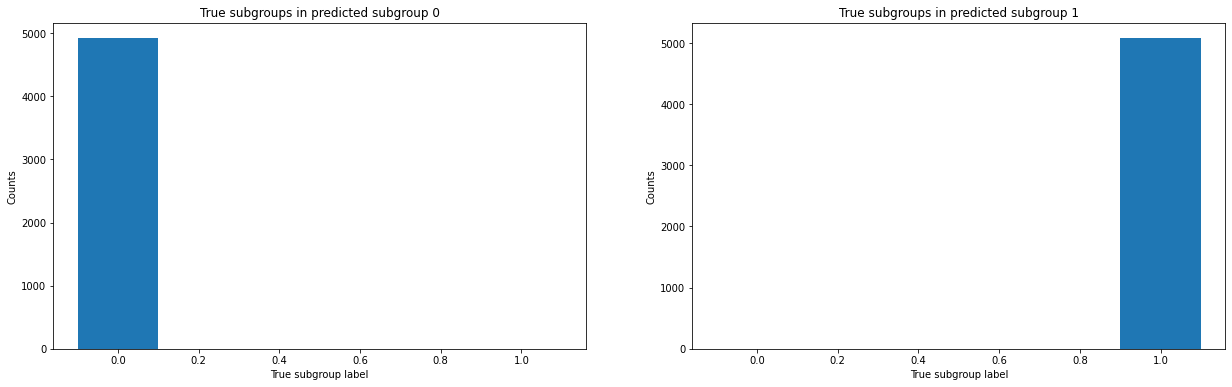

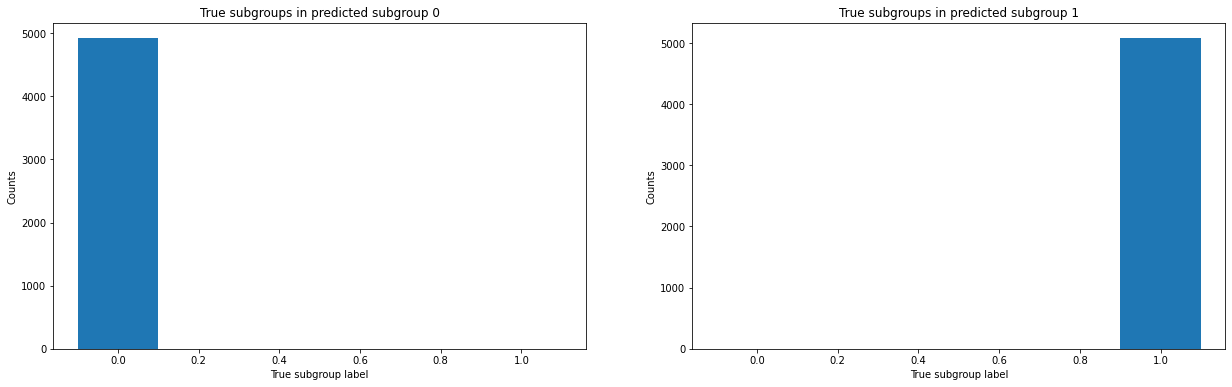

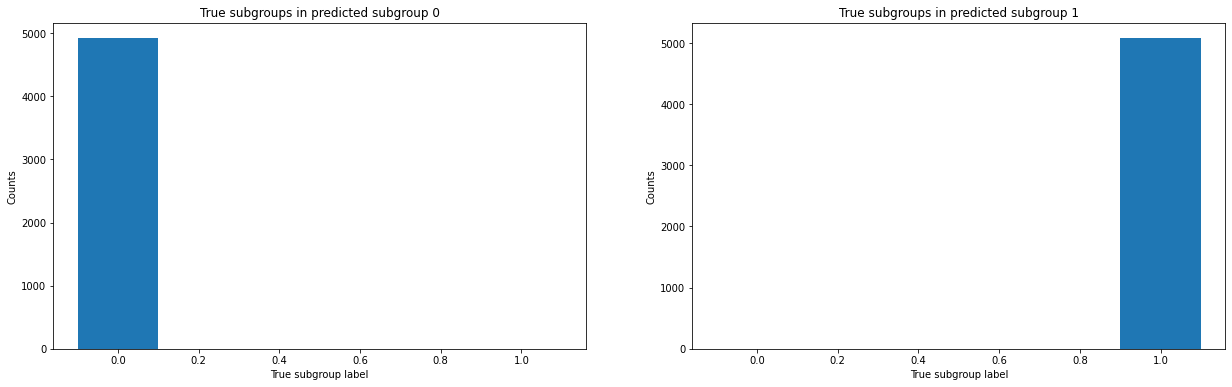

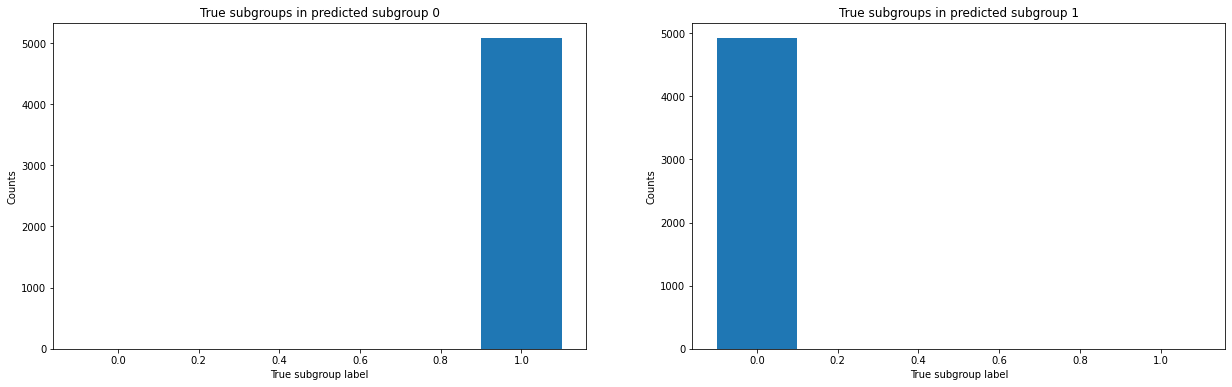

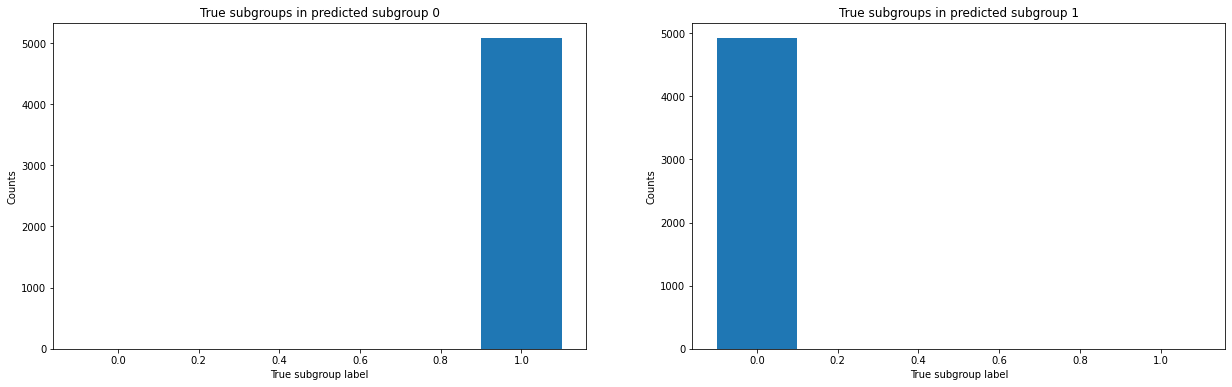

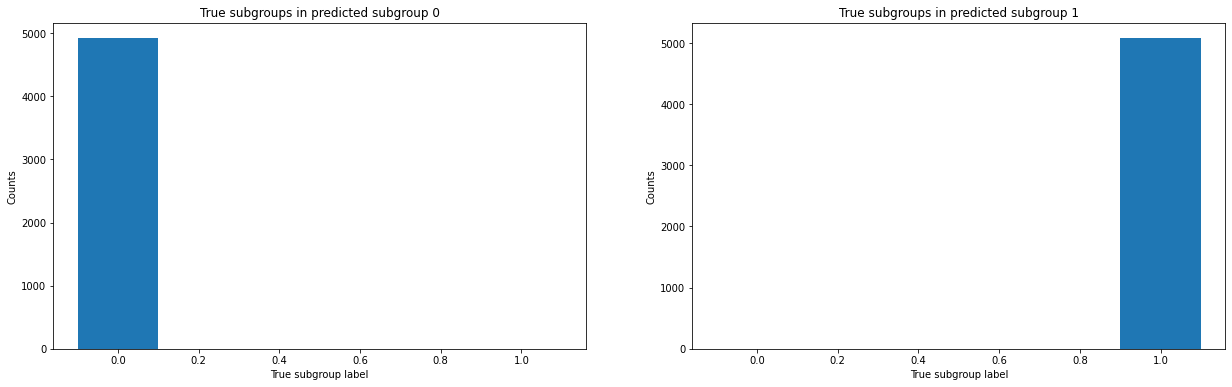

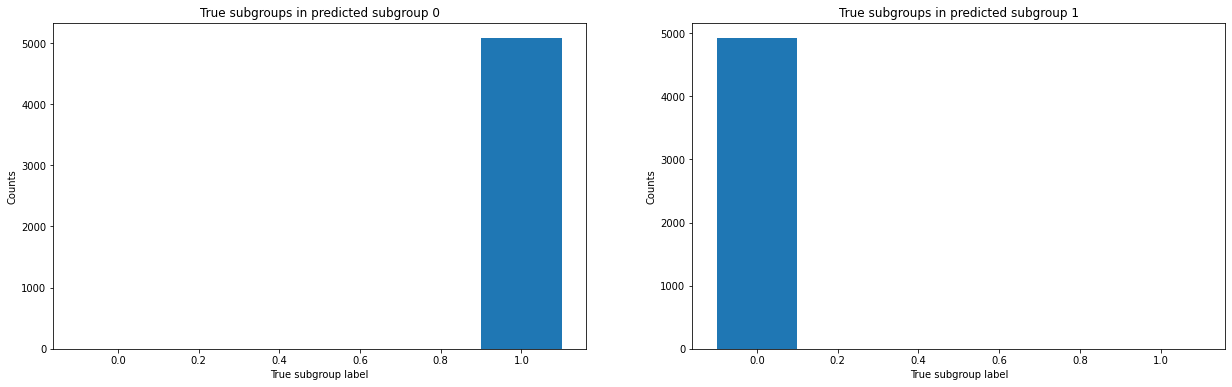

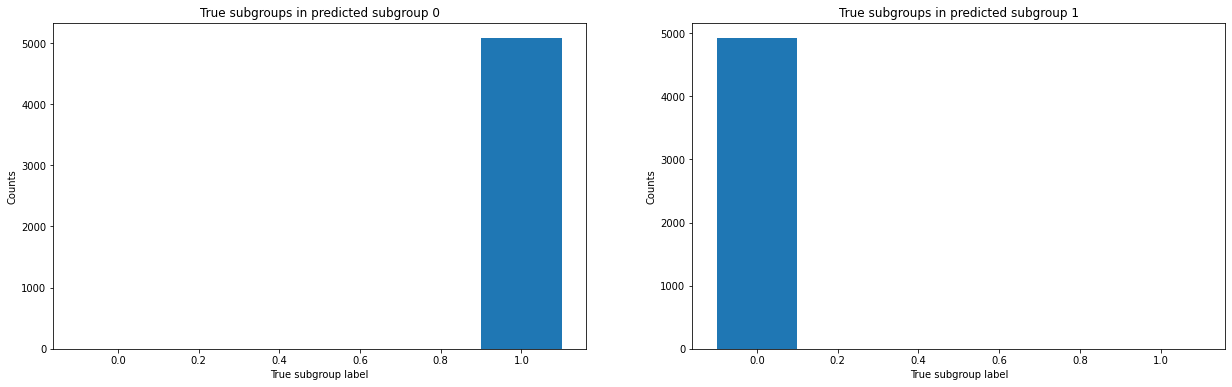

In [19]:
plot_hist_subgroups(n_runs=10, num_subgroups=2, dataset=cmnist_te, indices=results['idx_te'], probs=results['probs_te'], check_bp=False)